First

Shape of original data: (10683, 11)
Columns: ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price']
       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR ? DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU ? IXR ? BBI ? BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL ? LKO ? BOM ? COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU ? NAG ? BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR ? NAG ? DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop   

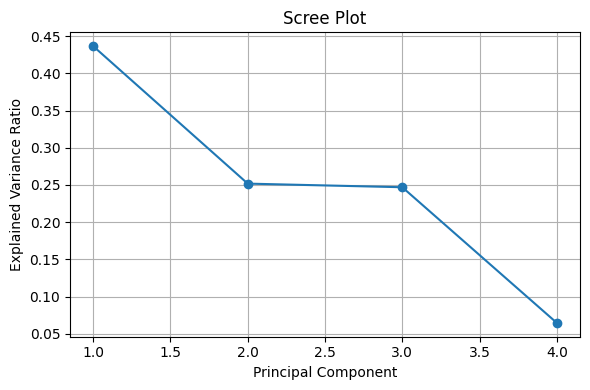

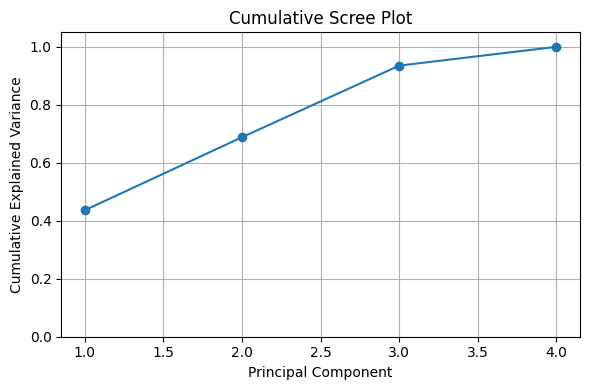

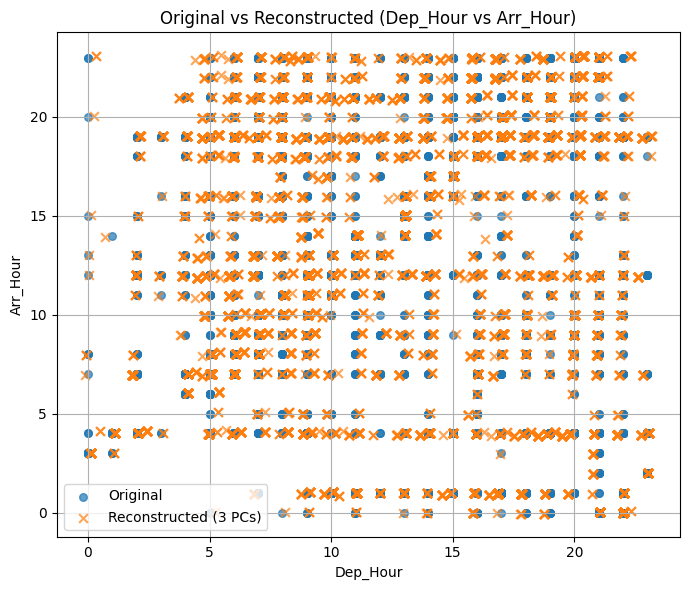

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ===============================
# 1. Load your dataset
# ===============================
file_path = "Data_Train.csv"   # adjust path if needed
df = pd.read_csv(file_path)

print("Shape of original data:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# ===============================
# 2. Feature Engineering (numeric)
# ===============================

# --- Duration -> Duration_Minutes ---
def parse_duration(s):
    """
    Convert '2h 50m', '19h', '50m' into total minutes (int).
    """
    s = str(s).strip()
    h = 0
    m = 0
    for part in s.split():
        if "h" in part:
            h = int(part.replace("h", ""))
        elif "m" in part:
            m = int(part.replace("m", ""))
    return h * 60 + m

df["Duration_Minutes"] = df["Duration"].apply(parse_duration)

# --- Dep_Time & Arrival_Time -> hours (0–23) ---
def parse_hour(s):
    """
    Take a time string like '22:20' or '01:10 22 Mar'
    and return the hour as integer.
    """
    s = str(s).strip().split()[0]  # keep only 'HH:MM'
    try:
        return int(s.split(":")[0])
    except Exception:
        return np.nan

df["Dep_Hour"] = df["Dep_Time"].apply(parse_hour)
df["Arr_Hour"] = df["Arrival_Time"].apply(parse_hour)

# --- Total_Stops -> numeric ---
stop_map = {"non-stop": 0}
for val in df["Total_Stops"].dropna().unique():
    if val not in stop_map:
        # '1 stop', '2 stops', etc.
        try:
            stop_map[val] = int(str(val).split()[0])
        except Exception:
            stop_map[val] = np.nan

df["Total_Stops_Num"] = df["Total_Stops"].map(stop_map)

print("\nHead with engineered features:")
print(df[["Duration", "Duration_Minutes",
          "Dep_Time", "Dep_Hour",
          "Arrival_Time", "Arr_Hour",
          "Total_Stops", "Total_Stops_Num"]].head())

# ===============================
# 3. Build X matrix for PCA
# ===============================
feature_names = ["Duration_Minutes", "Dep_Hour", "Arr_Hour", "Total_Stops_Num"]

# Drop rows with missing values in these features
df_clean = df[feature_names].dropna()
X = df_clean.values
print("\nPCA will be performed on features:", feature_names)
print("Number of samples used for PCA:", X.shape[0])

# ===============================
# 4. Standardize the data
# ===============================
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# ===============================
# 5. Run PCA (all components)
# ===============================
pca = PCA()  # all components
X_pca = pca.fit_transform(X_std)

expl_var = pca.explained_variance_ratio_
cum_expl_var = np.cumsum(expl_var)

print("\nExplained variance ratio by component:")
for i, (ev, cev) in enumerate(zip(expl_var, cum_expl_var), start=1):
    print(f"PC{i}: {ev:.4f}  |  Cumulative: {cev:.4f}")

# ----- Choose m* such that cumulative explained variance >= 80% -----
threshold = 0.80
m_star = np.argmax(cum_expl_var >= threshold) + 1
print(f"\nChosen m* = {m_star} principal components "
      f"(cumulative variance ≥ {threshold*100:.0f}%).")

# ===============================
# 6. Reduced PCA: keep only first m* PCs
# ===============================
pca_reduced = PCA(n_components=m_star)
X_pca_m = pca_reduced.fit_transform(X_std)

print(f"\nUsing only the first {m_star} principal components.")
print("Shape of reduced PCA matrix:", X_pca_m.shape)

# --- Reconstruct from the m* PCs ---
X_rec_std = pca_reduced.inverse_transform(X_pca_m)
X_rec = scaler.inverse_transform(X_rec_std)

# Build DataFrames for original vs reconstructed
df_orig = df_clean.copy()
df_rec = pd.DataFrame(X_rec, columns=feature_names, index=df_clean.index)

# ===============================
# 7. Print reconstruction values
# ===============================
print("\nReconstructed values (first 10 rows):")
print(df_rec.head(10))

print("\nOriginal vs Reconstructed (first 10 rows):")
print(pd.concat(
    [df_orig.head(10).add_suffix("_orig"),
     df_rec.head(10).add_suffix("_rec")],
    axis=1
))

print("\nReconstruction error (first 10 rows):")
print((df_orig - df_rec).head(10))

# ===============================
# 8. Scree plot
# ===============================
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(expl_var) + 1), expl_var, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# 9. Cumulative scree plot
# ===============================
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cum_expl_var) + 1), cum_expl_var, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Scree Plot")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# 11. 2D overlay: Original vs Reconstructed (Dep_Hour vs Arr_Hour)
# ===============================
x_col = "Dep_Hour"
y_col = "Arr_Hour"

plt.figure(figsize=(7, 6))
plt.scatter(df_orig[x_col], df_orig[y_col],
            alpha=0.7, label="Original", s=30)
plt.scatter(df_rec[x_col], df_rec[y_col],
            alpha=0.7, label=f"Reconstructed ({m_star} PCs)",
            marker="x", s=40)

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Original vs Reconstructed ({x_col} vs {y_col})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Second

✅ Loaded flight dataset.
Shape: (10683, 11)
Columns: ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price']

--- Summary Statistics (Price) ---
Min:    1759.00
Max:    79512.00
Range:  77753.00
Median: 8372.00

--- Cluster Counts (Class 0 = Cheap, Class 1 = Expensive) ---
cluster
Class 0 (Cheap ≤ median)        5370
Class 1 (Expensive > median)    5313
Name: count, dtype: int64


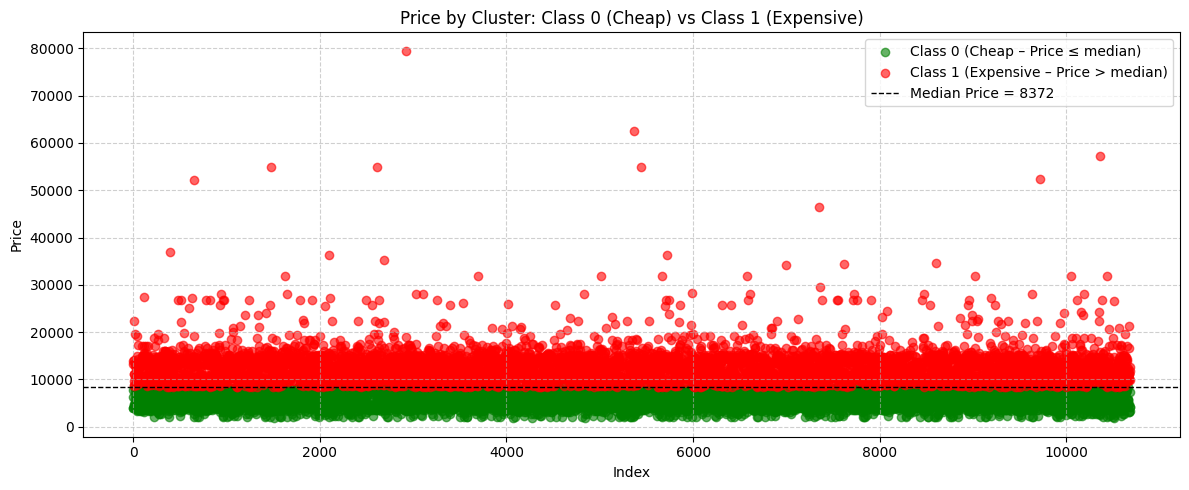


Reconstructed feature head (for NN input):
   Duration_Minutes_rec  Dep_Hour_rec  Arr_Hour_rec  Total_Stops_Num_rec
0            124.255002     22.044468      1.010721             0.060970
1            955.406132      4.503845     12.880379             1.319720
2           1314.391824      8.830477      3.959129             1.767567
3            575.809321     17.756194     22.941219             0.665716
4            546.870306     15.745441     20.938627             0.650974
Epoch 100/1000, Loss: 0.4320
Epoch 200/1000, Loss: 0.4206
Epoch 300/1000, Loss: 0.4179
Epoch 400/1000, Loss: 0.4159
Epoch 500/1000, Loss: 0.4143
Epoch 600/1000, Loss: 0.4129
Epoch 700/1000, Loss: 0.4118
Epoch 800/1000, Loss: 0.4107
Epoch 900/1000, Loss: 0.4100
Epoch 1000/1000, Loss: 0.4094

Training Accuracy: 81.77%
Training Confusion Matrix:
[[2534 1224]
 [ 139 3580]]

Validation Accuracy: 82.25%
Validation Confusion Matrix:
[[1100  511]
 [  58 1536]]

Training Misclassification Error: 0.1823
Validation Misclass

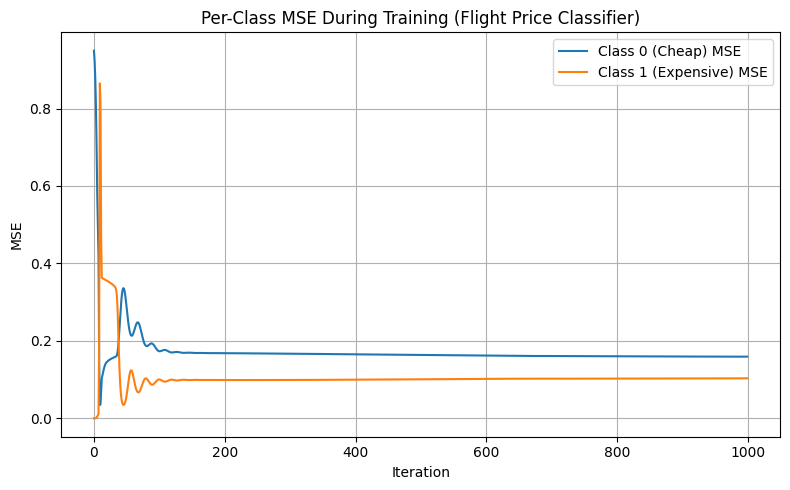

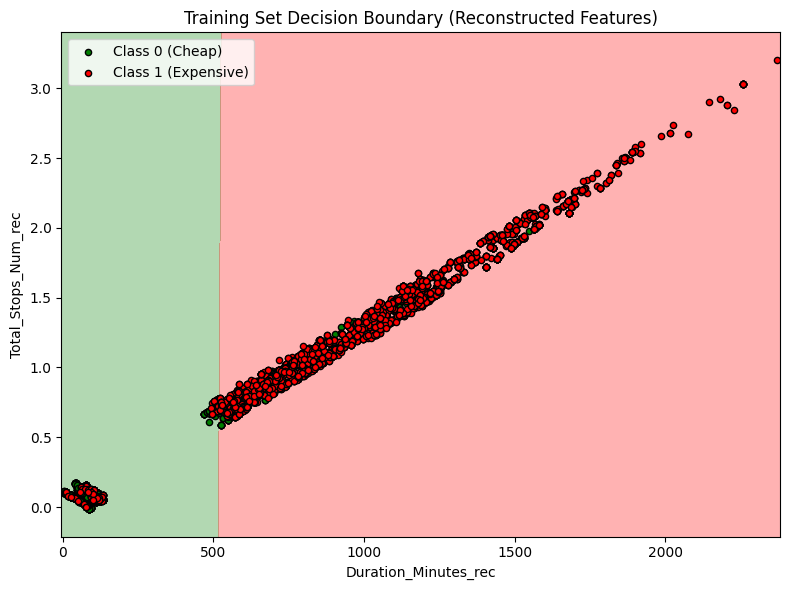

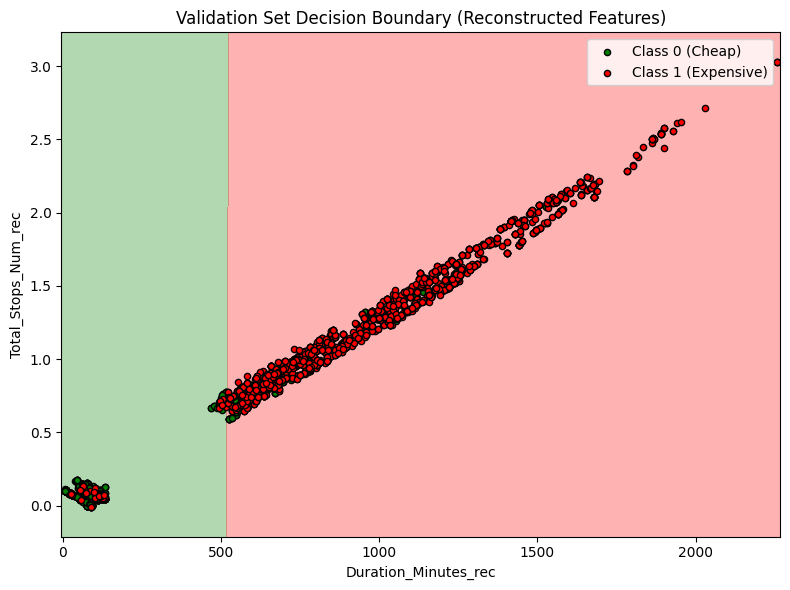

Trial 1/20 - Class 0 MSE: 0.2449, Class 1 MSE: 0.1383, Overall MSE: 0.1919
Trial 2/20 - Class 0 MSE: 0.2337, Class 1 MSE: 0.1383, Overall MSE: 0.1862
Trial 3/20 - Class 0 MSE: 0.0000, Class 1 MSE: 1.0000, Overall MSE: 0.4974
Trial 4/20 - Class 0 MSE: 0.2542, Class 1 MSE: 0.1317, Overall MSE: 0.1933
Trial 5/20 - Class 0 MSE: 0.2989, Class 1 MSE: 0.0508, Overall MSE: 0.1755
Trial 6/20 - Class 0 MSE: 0.2235, Class 1 MSE: 0.1505, Overall MSE: 0.1872
Trial 7/20 - Class 0 MSE: 0.2486, Class 1 MSE: 0.1261, Overall MSE: 0.1876
Trial 8/20 - Class 0 MSE: 0.2393, Class 1 MSE: 0.1355, Overall MSE: 0.1876
Trial 9/20 - Class 0 MSE: 0.0000, Class 1 MSE: 1.0000, Overall MSE: 0.4974
Trial 10/20 - Class 0 MSE: 0.3287, Class 1 MSE: 0.0489, Overall MSE: 0.1895
Trial 11/20 - Class 0 MSE: 0.2635, Class 1 MSE: 0.1298, Overall MSE: 0.1970
Trial 12/20 - Class 0 MSE: 0.0000, Class 1 MSE: 1.0000, Overall MSE: 0.4974
Trial 13/20 - Class 0 MSE: 0.2672, Class 1 MSE: 0.0847, Overall MSE: 0.1764
Trial 14/20 - Class 0

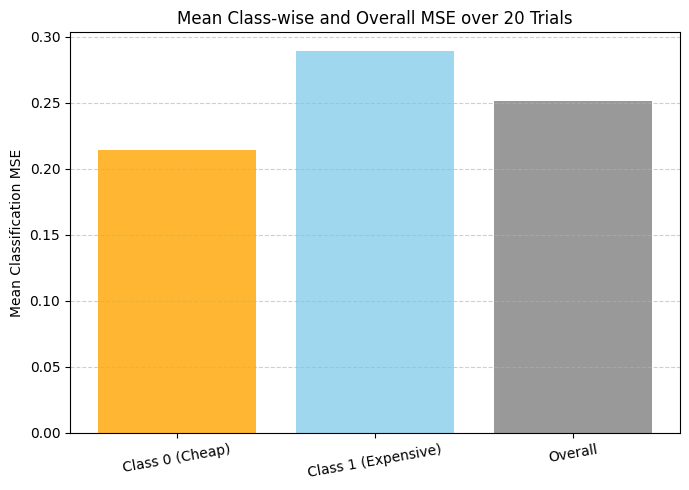

[Fine-tuned] Epoch 100/1000, Loss: 0.4377
[Fine-tuned] Epoch 200/1000, Loss: 0.4174
[Fine-tuned] Epoch 300/1000, Loss: 0.4118
[Fine-tuned] Epoch 400/1000, Loss: 0.4101
[Fine-tuned] Epoch 500/1000, Loss: 0.4087
[Fine-tuned] Epoch 600/1000, Loss: 0.4085
[Fine-tuned] Epoch 700/1000, Loss: 0.4069
[Fine-tuned] Epoch 800/1000, Loss: 0.4065
[Fine-tuned] Epoch 900/1000, Loss: 0.4080
[Fine-tuned] Epoch 1000/1000, Loss: 0.4053

Fine-tuned Training Accuracy: 82.00%
Fine-tuned Training Confusion Matrix:
[[2700 1058]
 [ 288 3431]]

Fine-tuned Validation Accuracy: 82.96%
Fine-tuned Validation Confusion Matrix:
[[1176  435]
 [ 111 1483]]

[Fine-tuned] Training Misclassification Error:   0.1800
[Fine-tuned] Validation Misclassification Error: 0.1704


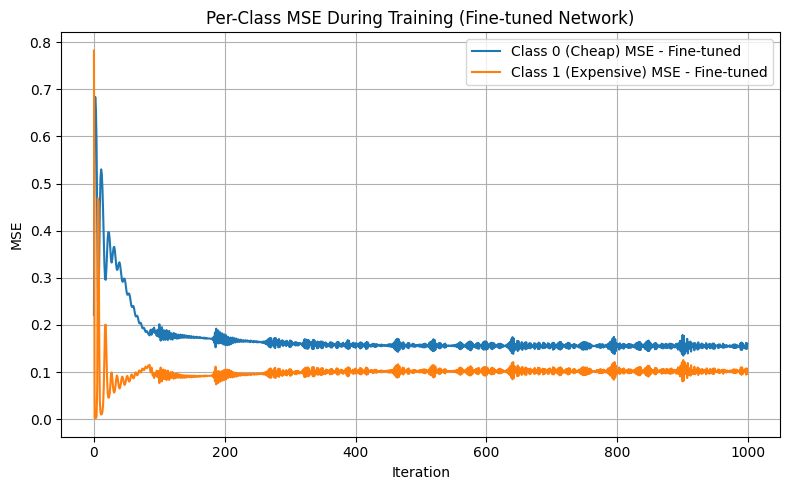

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# ============================================================
# PART A — Price: Summary, Clusters, and Scatter Plot
# ============================================================

FILE_PATH = "Data_Train.csv"

try:
    # 1. Load dataset
    df_raw = pd.read_csv(FILE_PATH)
    print("✅ Loaded flight dataset.")
    print("Shape:", df_raw.shape)
    print("Columns:", df_raw.columns.tolist())

    # Ensure Price is numeric
    df_raw["Price"] = pd.to_numeric(df_raw["Price"], errors="coerce")
    df_raw = df_raw.dropna(subset=["Price"])

    if df_raw.empty:
        raise ValueError("No valid numeric data found in 'Price'.")

    # 2. Summary stats for Price
    price_min = df_raw["Price"].min()
    price_max = df_raw["Price"].max()
    price_range = price_max - price_min
    price_median = df_raw["Price"].median()

    print("\n--- Summary Statistics (Price) ---")
    print(f"Min:    {price_min:.2f}")
    print(f"Max:    {price_max:.2f}")
    print(f"Range:  {price_range:.2f}")
    print(f"Median: {price_median:.2f}")

   # 3. Define binary cluster: cheap (0) vs expensive (1)
    df_raw["cluster"] = (df_raw["Price"] > price_median).astype(int)

    print("\n--- Cluster Counts (Class 0 = Cheap, Class 1 = Expensive) ---")
    print(
        df_raw["cluster"]
        .value_counts()
        .rename(index={0: "Class 0 (Cheap ≤ median)", 1: "Class 1 (Expensive > median)"})
    )

    # 4. Scatter plot of Price over index, colored by cluster
    plt.figure(figsize=(12, 5))

    colors = {
        0: "green",   # Class 0
        1: "red"      # Class 1
    }

    labels = {
        0: "Class 0 (Cheap – Price ≤ median)",
        1: "Class 1 (Expensive – Price > median)"
    }

    for c, g in df_raw.groupby("cluster"):
        plt.scatter(
            g.index,
            g["Price"],
            color=colors[c],
            alpha=0.6,
            label=labels[c],
        )

    plt.axhline(
        price_median,
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"Median Price = {price_median:.0f}"
    )

    plt.title("Price by Cluster: Class 0 (Cheap) vs Class 1 (Expensive)")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


except FileNotFoundError:
    print(f"❌ File not found: {FILE_PATH}")
except Exception as e:
    print(f"⚠️ Error in PART A: {e}")


# ============================================================
# PART B — PCA (3 PCs) → Reconstruct → Neural Network on 𝑋̂
#          Predict: Cheap vs Expensive (cluster)
# ============================================================

try:
    # =========================
    # 1. Load again & Feature Engineering
    # =========================
    df = pd.read_csv(FILE_PATH)

    # --- Duration -> Duration_Minutes ---
    def parse_duration(s):
        s = str(s).strip()
        h = 0
        m = 0
        for part in s.split():
            if "h" in part:
                h = int(part.replace("h", ""))
            elif "m" in part:
                m = int(part.replace("m", ""))
        return h * 60 + m

    df["Duration_Minutes"] = df["Duration"].apply(parse_duration)

    # --- Dep_Time & Arrival_Time -> hours (0–23) ---
    def parse_hour(s):
        s = str(s).strip().split()[0]  # keep only 'HH:MM'
        try:
            return int(s.split(":")[0])
        except Exception:
            return np.nan

    df["Dep_Hour"] = df["Dep_Time"].apply(parse_hour)
    df["Arr_Hour"] = df["Arrival_Time"].apply(parse_hour)

    # --- Total_Stops -> numeric ---
    stop_map = {"non-stop": 0}
    for val in df["Total_Stops"].dropna().unique():
        if val not in stop_map:
            try:
                stop_map[val] = int(str(val).split()[0])  # '1 stop' -> 1
            except Exception:
                stop_map[val] = np.nan

    df["Total_Stops_Num"] = df["Total_Stops"].map(stop_map)

    # Keep Price and engineered numeric features
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

    # Drop rows with missing values in key columns
    feature_names = ["Duration_Minutes", "Dep_Hour", "Arr_Hour", "Total_Stops_Num"]
    df = df.dropna(subset=["Price"] + feature_names)

    # Binary target (same definition as Part A)
    price_median = df["Price"].median()
    df["cluster"] = (df["Price"] > price_median).astype(int)
    y = df["cluster"].values

    # =========================
    # 2. PCA with 3 PCs on the 4 engineered features
    # =========================
    X_original_features = df[feature_names].values

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_original_features)

    # Keep 3 PCs (m* = 3) and reconstruct to feature space
    pca_reduced = PCA(n_components=3)
    X_pca_3 = pca_reduced.fit_transform(X_std)
    X_rec_std = pca_reduced.inverse_transform(X_pca_3)
    X_rec = scaler.inverse_transform(X_rec_std)

    # Build DataFrame of reconstructed features (𝑋̂ in feature space)
    rec_cols = [f"{name}_rec" for name in feature_names]
    df_rec = pd.DataFrame(X_rec, columns=rec_cols, index=df.index)

    # Combine reconstructed features with Price and cluster label
    df_model = pd.concat([df[["Price", "cluster"]], df_rec], axis=1)

    print("\nReconstructed feature head (for NN input):")
    print(df_model[rec_cols].head())

    # =========================
    # 3. X̂ and y for the neural network
    # =========================
    X = df_model[rec_cols].values       # shape (n_samples, 4)
    y = df_model["cluster"].values      # 0 = cheap, 1 = expensive

    # Train/Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # =========================
    # 4. Neural Network (m, 8, 4, 1)
    # =========================
    class TwoLayerNN(nn.Module):
        def __init__(self, input_size):
            super(TwoLayerNN, self).__init__()
            self.hidden1 = nn.Linear(input_size, 8)
            self.hidden2 = nn.Linear(8, 4)
            self.output = nn.Linear(4, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = torch.relu(self.hidden1(x))
            x = torch.relu(self.hidden2(x))
            x = self.sigmoid(self.output(x))
            return x

    model = TwoLayerNN(input_size=X.shape[1])  # input_size = 4 reconstructed features

    # =========================
    # 5. Loss and Optimizer
    # =========================
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # =========================
    # 6. Training + Tracking Class-wise MSE
    # =========================
    mse_class0 = []
    mse_class1 = []

    n_epochs = 1000
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # ---- Per-class MSE tracking ----
        with torch.no_grad():
            errors = (outputs - y_train_tensor) ** 2
            class0_mask = (y_train_tensor == 0).view(-1)
            class1_mask = (y_train_tensor == 1).view(-1)

            mse0 = errors[class0_mask].mean().item()
            mse1 = errors[class1_mask].mean().item()

            mse_class0.append(mse0)
            mse_class1.append(mse1)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")



    # =========================
    # 7. Evaluation helpers
    # =========================
    def evaluate_model(X_tensor, y_tensor, name="Dataset"):
        with torch.no_grad():
            probs = model(X_tensor)
            pred = (probs >= 0.5).float()
            acc = (pred == y_tensor).sum() / y_tensor.size(0)
            cm = confusion_matrix(y_tensor.numpy().ravel(), pred.numpy().ravel())
            print(f"\n{name} Accuracy: {acc.item()*100:.2f}%")
            print(f"{name} Confusion Matrix:\n{cm}")
        return pred

    def misclassification_error(y_true, y_pred):
        return (y_true != y_pred).float().mean().item()

    train_pred = evaluate_model(X_train_tensor, y_train_tensor, "Training")
    val_pred = evaluate_model(X_val_tensor, y_val_tensor, "Validation")

    train_error = misclassification_error(y_train_tensor, train_pred)
    val_error = misclassification_error(y_val_tensor, val_pred)

    print(f"\nTraining Misclassification Error: {train_error:.4f}")
    print(f"Validation Misclassification Error: {val_error:.4f}")

    print("Final baseline Class 0 MSE:", mse_class0[-1])
    print("Final baseline Class 1 MSE:", mse_class1[-1])
    # =========================
    # 8. Plot MSE per class vs iteration
    # =========================
    plt.figure(figsize=(8, 5))
    plt.plot(mse_class0, label="Class 0 (Cheap) MSE")
    plt.plot(mse_class1, label="Class 1 (Expensive) MSE")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.title("Per-Class MSE During Training (Flight Price Classifier)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # =========================
    # 9. Decision Boundary Plot using 2 reconstructed features
    # =========================
    # We'll visualize in the plane:
    #   Duration_Minutes_rec (x-axis) vs Total_Stops_Num_rec (y-axis)
    dur_idx = rec_cols.index("Duration_Minutes_rec")
    stops_idx = rec_cols.index("Total_Stops_Num_rec")

    # Mean of each reconstructed feature (used to fix the other dims)
    mean_vals = X.mean(axis=0)

    def plot_decision_boundary(X_arr, y_arr, model_obj, title="Decision Boundary"):
        plt.figure(figsize=(8, 6))

        x_min, x_max = X_arr[:, dur_idx].min() - 10, X_arr[:, dur_idx].max() + 10
        y_min, y_max = X_arr[:, stops_idx].min() - 0.2, X_arr[:, stops_idx].max() + 0.2

        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 200),
            np.linspace(y_min, y_max, 200)
        )

        # Build full 4D grid: two dims vary, other two fixed at mean
        grid_full = np.zeros((xx.size, X_arr.shape[1]))
        grid_full[:, :] = mean_vals  # start with means
        grid_full[:, dur_idx] = xx.ravel()
        grid_full[:, stops_idx] = yy.ravel()

        grid_tensor = torch.tensor(grid_full, dtype=torch.float32)

        with torch.no_grad():
            Z = model_obj(grid_tensor).numpy().reshape(xx.shape)

        # Background: decision regions
        plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3,
                     colors=['green', 'red'])

        # Overlay data points (projected to the same 2 dims)
        plt.scatter(X_arr[y_arr == 0, dur_idx], X_arr[y_arr == 0, stops_idx],
                    color='green', label='Class 0 (Cheap)', edgecolor='k', s=20)
        plt.scatter(X_arr[y_arr == 1, dur_idx], X_arr[y_arr == 1, stops_idx],
                    color='red', label='Class 1 (Expensive)', edgecolor='k', s=20)

        plt.xlabel("Duration_Minutes_rec")
        plt.ylabel("Total_Stops_Num_rec")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_decision_boundary(X_train, y_train, model,
                           "Training Set Decision Boundary (Reconstructed Features)")
    plot_decision_boundary(X_val, y_val, model,
                           "Validation Set Decision Boundary (Reconstructed Features)")

    # =========================
    # 10. Part III(iii): M random 80–20 trials
    # =========================
    M = 20  # number of random trials

    mse0_trials = []      # Class 0 (Cheap)
    mse1_trials = []      # Class 1 (Expensive)
    mse_overall_trials = []

    for trial in range(M):
        X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=None
        )

        X_train_tens = torch.tensor(X_train_t, dtype=torch.float32)
        y_train_tens = torch.tensor(y_train_t, dtype=torch.float32).view(-1, 1)
        X_test_tens  = torch.tensor(X_test_t,  dtype=torch.float32)
        y_test_tens  = torch.tensor(y_test_t,  dtype=torch.float32).view(-1, 1)

        model_t = TwoLayerNN(input_size=X.shape[1])
        criterion_t = nn.BCELoss()
        optimizer_t = optim.Adam(model_t.parameters(), lr=0.01)

        n_epochs_t = 500
        for epoch in range(n_epochs_t):
            optimizer_t.zero_grad()
            out_t = model_t(X_train_tens)
            loss_t = criterion_t(out_t, y_train_tens)
            loss_t.backward()
            optimizer_t.step()

        with torch.no_grad():
            probs_t = model_t(X_test_tens)
            preds_t = (probs_t >= 0.5).float()
            sq_err  = (preds_t - y_test_tens) ** 2

            overall_mse = sq_err.mean().item()

            mask0 = (y_test_tens == 0).view(-1)
            mask1 = (y_test_tens == 1).view(-1)

            mse0 = sq_err[mask0].mean().item()
            mse1 = sq_err[mask1].mean().item()

        mse0_trials.append(mse0)
        mse1_trials.append(mse1)
        mse_overall_trials.append(overall_mse)

        print(f"Trial {trial+1}/{M} - "
              f"Class 0 MSE: {mse0:.4f}, "
              f"Class 1 MSE: {mse1:.4f}, "
              f"Overall MSE: {overall_mse:.4f}")

    mean_mse0 = np.mean(mse0_trials)
    mean_mse1 = np.mean(mse1_trials)
    mean_mse_overall = np.mean(mse_overall_trials)

    print("\n=== Part III(iii): Mean classification MSE over "
          f"{M} trials (80–20 splits) ===")
    print(f"Class 0 (Cheap)     mean MSE: {mean_mse0:.4f}")
    print(f"Class 1 (Expensive) mean MSE: {mean_mse1:.4f}")
    print(f"Overall             mean MSE: {mean_mse_overall:.4f}")

    plt.figure(figsize=(7, 5))

    x_vals = [1, 2, 3]
    labels_plot = ["Class 0 (Cheap)", "Class 1 (Expensive)", "Overall"]
    means_plot  = [mean_mse0, mean_mse1, mean_mse_overall]

    # --- Bar Plot Version ---
    plt.bar(x_vals, means_plot, color=["orange", "skyblue", "gray"], alpha=0.8)

    plt.xticks(x_vals, labels_plot, rotation=10)
    plt.ylabel("Mean Classification MSE")
    plt.title(f"Mean Class-wise and Overall MSE over {M} Trials")
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


    # =========================
    # 11. Part IV: Fine-tuned network <m, 16, 8, 4, (c-1)>
    # =========================
    class FineTunedNN(nn.Module):
        def __init__(self, input_size):
            super(FineTunedNN, self).__init__()
            self.hidden1 = nn.Linear(input_size, 16)
            self.hidden2 = nn.Linear(16, 8)
            self.hidden3 = nn.Linear(8, 4)
            self.output  = nn.Linear(4, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = torch.relu(self.hidden1(x))
            x = torch.relu(self.hidden2(x))
            x = torch.relu(self.hidden3(x))
            x = self.sigmoid(self.output(x))
            return x

    fine_model = FineTunedNN(input_size=X.shape[1])
    criterion_ft = nn.BCELoss()
    optimizer_ft = optim.Adam(fine_model.parameters(), lr=0.01)

    n_epochs_ft = 1000
    mse_class0_ft = []
    mse_class1_ft = []

    for epoch in range(n_epochs_ft):
        optimizer_ft.zero_grad()
        out_ft = fine_model(X_train_tensor)
        loss_ft = criterion_ft(out_ft, y_train_tensor)
        loss_ft.backward()
        optimizer_ft.step()

        with torch.no_grad():
            errors_ft = (out_ft - y_train_tensor) ** 2
            mask0_ft = (y_train_tensor == 0).view(-1)
            mask1_ft = (y_train_tensor == 1).view(-1)

            mse0_ft = errors_ft[mask0_ft].mean().item()
            mse1_ft = errors_ft[mask1_ft].mean().item()

            mse_class0_ft.append(mse0_ft)
            mse_class1_ft.append(mse1_ft)

        if (epoch + 1) % 100 == 0:
            print(f"[Fine-tuned] Epoch {epoch+1}/{n_epochs_ft}, Loss: {loss_ft.item():.4f}")

    def evaluate_with_model(model_obj, X_tensor, y_tensor, name="Dataset"):
        with torch.no_grad():
            probs = model_obj(X_tensor)
            pred = (probs >= 0.5).float()
            acc = (pred == y_tensor).sum() / y_tensor.size(0)
            cm = confusion_matrix(y_tensor.numpy().ravel(), pred.numpy().ravel())
            print(f"\n{name} Accuracy: {acc.item()*100:.2f}%")
            print(f"{name} Confusion Matrix:\n{cm}")
        return pred

    ft_train_pred = evaluate_with_model(fine_model, X_train_tensor, y_train_tensor,
                                        "Fine-tuned Training")
    ft_val_pred   = evaluate_with_model(fine_model, X_val_tensor,   y_val_tensor,
                                        "Fine-tuned Validation")

    ft_train_err = misclassification_error(y_train_tensor, ft_train_pred)
    ft_val_err   = misclassification_error(y_val_tensor,   ft_val_pred)

    print(f"\n[Fine-tuned] Training Misclassification Error:   {ft_train_err:.4f}")
    print(f"[Fine-tuned] Validation Misclassification Error: {ft_val_err:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(mse_class0_ft, label="Class 0 (Cheap) MSE - Fine-tuned")
    plt.plot(mse_class1_ft, label="Class 1 (Expensive) MSE - Fine-tuned")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.title("Per-Class MSE During Training (Fine-tuned Network)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    x_vals = [1, 2, 3]

except FileNotFoundError:
    print(f"❌ File not found: {FILE_PATH}")
except Exception as e:
    print(f"⚠️ Error in PART B: {e}")


Part v

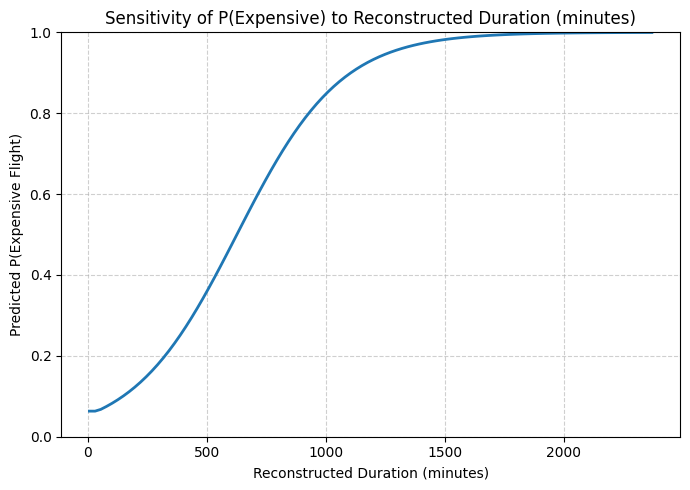

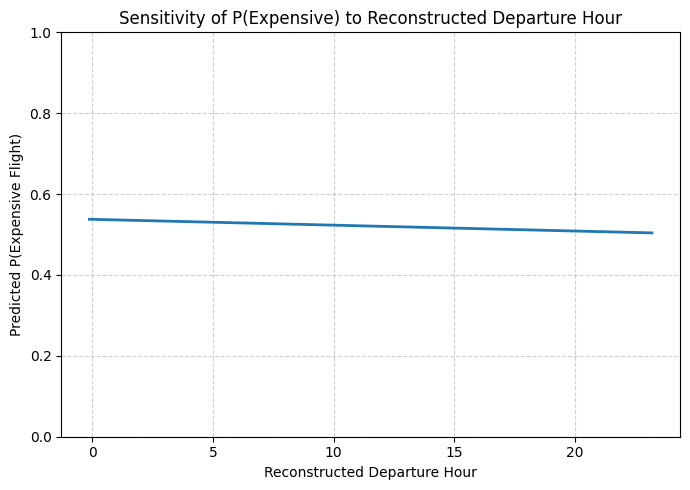

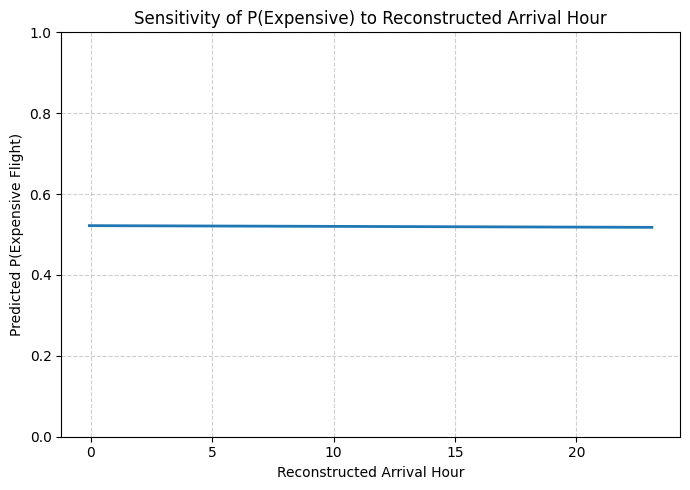

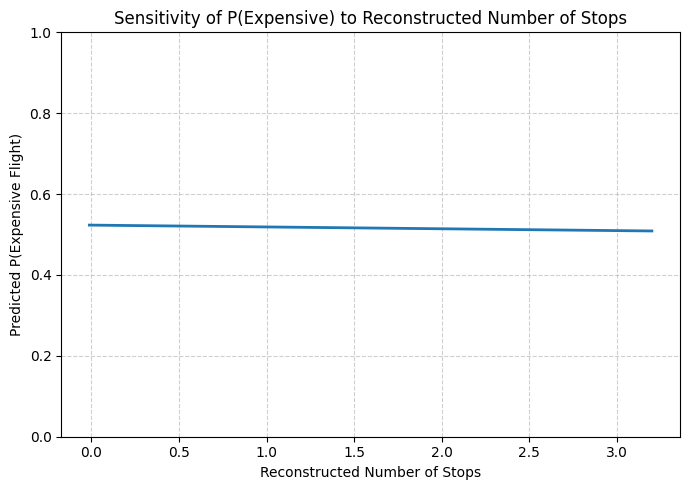

In [ ]:
    # =========================
    # Part V: Sensitivity Analysis
    # How does each reconstructed feature affect P(Expensive)?
    # =========================

    # We use the ORIGINAL network `model` (m, 8, 4, 1) trained on X̂
    # and vary ONE feature at a time while holding the others at their mean.

    # Display-friendly names for plots
    feature_display_names = {
        "Duration_Minutes_rec": "Reconstructed Duration (minutes)",
        "Dep_Hour_rec": "Reconstructed Departure Hour",
        "Arr_Hour_rec": "Reconstructed Arrival Hour",
        "Total_Stops_Num_rec": "Reconstructed Number of Stops"
    }

    # Baseline: mean of each reconstructed feature (over the whole dataset)
    baseline = X.mean(axis=0)   # shape (4,)

    for j, col in enumerate(rec_cols):
        # 1. Create a grid of values for this feature, over its observed range
        feat_min = X[:, j].min()
        feat_max = X[:, j].max()

        # Slightly extend the range to make plots nicer
        grid_vals = np.linspace(feat_min, feat_max, 100)

        # 2. Build an input matrix where:
        #    - all features start at baseline mean
        #    - column j is replaced by the grid values
        X_sens = np.tile(baseline, (len(grid_vals), 1))   # shape (100, 4)
        X_sens[:, j] = grid_vals

        # 3. Pass through the ORIGINAL trained model to get P(Expensive)
        X_sens_tensor = torch.tensor(X_sens, dtype=torch.float32)
        with torch.no_grad():
            probs = model(X_sens_tensor).numpy().ravel()  # P(class 1 = Expensive)

        # 4. Plot: feature value vs predicted probability of Expensive
        plt.figure(figsize=(7, 5))
        plt.plot(grid_vals, probs, linewidth=2)

        plt.xlabel(feature_display_names.get(col, col))
        plt.ylabel("Predicted P(Expensive Flight)")
        plt.title(f"Sensitivity of P(Expensive) to {feature_display_names.get(col, col)}")
        plt.ylim(0, 1)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()


New_Part For 2 PC'S

Shape of original data: (10683, 11)
Columns: ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price']
       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR ? DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU ? IXR ? BBI ? BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL ? LKO ? BOM ? COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU ? NAG ? BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR ? NAG ? DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop   

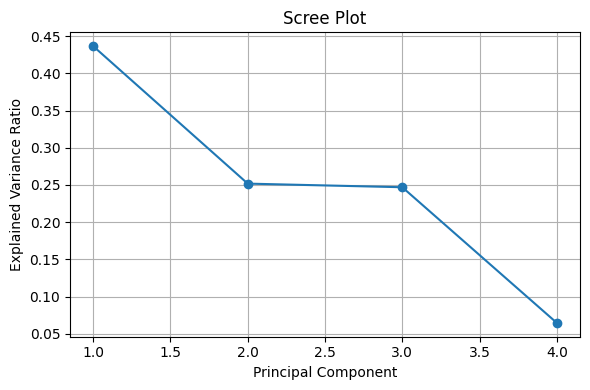

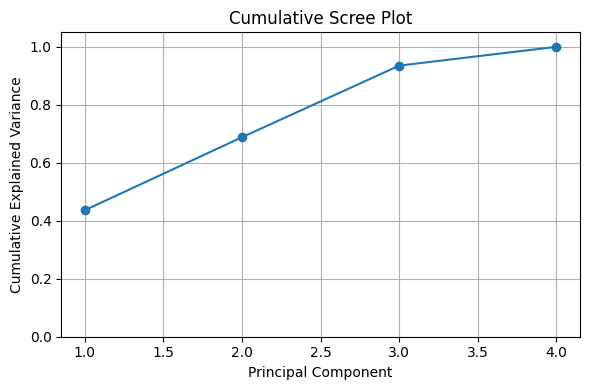

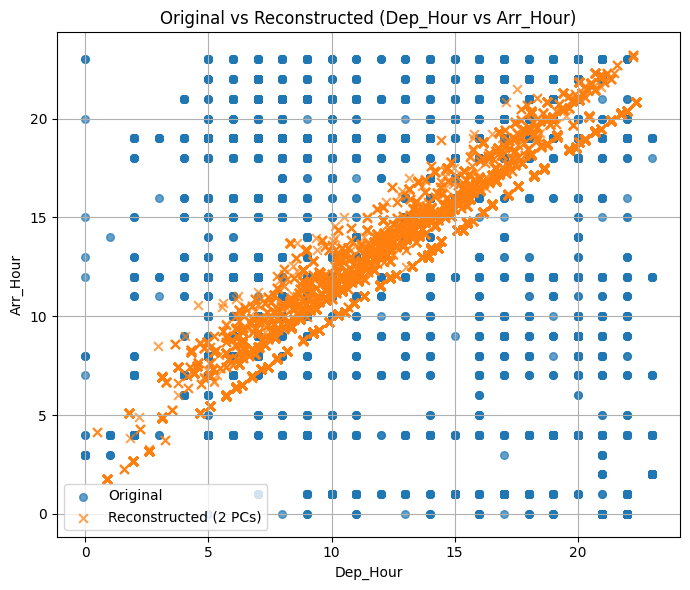

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ===============================
# 1. Load your dataset
# ===============================
file_path = "Data_Train.csv"   # adjust path if needed
df = pd.read_csv(file_path)

print("Shape of original data:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# ===============================
# 2. Feature Engineering (numeric)
# ===============================

# --- Duration -> Duration_Minutes ---
def parse_duration(s):
    """
    Convert '2h 50m', '19h', '50m' into total minutes (int).
    """
    s = str(s).strip()
    h = 0
    m = 0
    for part in s.split():
        if "h" in part:
            h = int(part.replace("h", ""))
        elif "m" in part:
            m = int(part.replace("m", ""))
    return h * 60 + m

df["Duration_Minutes"] = df["Duration"].apply(parse_duration)

# --- Dep_Time & Arrival_Time -> hours (0–23) ---
def parse_hour(s):
    """
    Take a time string like '22:20' or '01:10 22 Mar'
    and return the hour as integer.
    """
    s = str(s).strip().split()[0]  # keep only 'HH:MM'
    try:
        return int(s.split(":")[0])
    except Exception:
        return np.nan

df["Dep_Hour"] = df["Dep_Time"].apply(parse_hour)
df["Arr_Hour"] = df["Arrival_Time"].apply(parse_hour)

# --- Total_Stops -> numeric ---
stop_map = {"non-stop": 0}
for val in df["Total_Stops"].dropna().unique():
    if val not in stop_map:
        # '1 stop', '2 stops', etc.
        try:
            stop_map[val] = int(str(val).split()[0])
        except Exception:
            stop_map[val] = np.nan

df["Total_Stops_Num"] = df["Total_Stops"].map(stop_map)

print("\nHead with engineered features:")
print(df[["Duration", "Duration_Minutes",
          "Dep_Time", "Dep_Hour",
          "Arrival_Time", "Arr_Hour",
          "Total_Stops", "Total_Stops_Num"]].head())

# ===============================
# 3. Build X matrix for PCA
# ===============================
feature_names = ["Duration_Minutes", "Dep_Hour", "Arr_Hour", "Total_Stops_Num"]

# Drop rows with missing values in these features
df_clean = df[feature_names].dropna()
X = df_clean.values
print("\nPCA will be performed on features:", feature_names)
print("Number of samples used for PCA:", X.shape[0])

# ===============================
# 4. Standardize the data
# ===============================
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# ===============================
# 5. Run PCA (all components) - just to inspect variance
# ===============================
pca_full = PCA()  # all components
X_pca_full = pca_full.fit_transform(X_std)

expl_var = pca_full.explained_variance_ratio_
cum_expl_var = np.cumsum(expl_var)

print("\nExplained variance ratio by component:")
for i, (ev, cev) in enumerate(zip(expl_var, cum_expl_var), start=1):
    print(f"PC{i}: {ev:.4f}  |  Cumulative: {cev:.4f}")

# ----- Force m* = 2 principal components -----
m_star = 2
print(f"\nFor this analysis we fix m* = {m_star} principal components.")

# ===============================
# 6. Reduced PCA: keep only first m* PCs
# ===============================
pca_reduced = PCA(n_components=m_star)
X_pca_m = pca_reduced.fit_transform(X_std)

print(f"\nUsing only the first {m_star} principal components.")
print("Shape of reduced PCA matrix:", X_pca_m.shape)

# --- Reconstruct from the m* PCs ---
X_rec_std = pca_reduced.inverse_transform(X_pca_m)
X_rec = scaler.inverse_transform(X_rec_std)

# Build DataFrames for original vs reconstructed
df_orig = df_clean.copy()
df_rec = pd.DataFrame(X_rec, columns=feature_names, index=df_clean.index)

# ===============================
# 7. Print reconstruction values
# ===============================
print("\nReconstructed values (first 10 rows):")
print(df_rec.head(10))

print("\nOriginal vs Reconstructed (first 10 rows):")
print(pd.concat(
    [df_orig.head(10).add_suffix("_orig"),
     df_rec.head(10).add_suffix("_rec")],
    axis=1
))

print("\nReconstruction error (first 10 rows):")
print((df_orig - df_rec).head(10))

# ===============================
# 8. Scree plot (from full PCA)
# ===============================
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(expl_var) + 1), expl_var, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# 9. Cumulative scree plot (from full PCA)
# ===============================
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cum_expl_var) + 1), cum_expl_var, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Scree Plot")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# 11. 2D overlay: Original vs Reconstructed (Dep_Hour vs Arr_Hour)
# ===============================
x_col = "Dep_Hour"
y_col = "Arr_Hour"

plt.figure(figsize=(7, 6))
plt.scatter(df_orig[x_col], df_orig[y_col],
            alpha=0.7, label="Original", s=30)
plt.scatter(df_rec[x_col], df_rec[y_col],
            alpha=0.7, label=f"Reconstructed ({m_star} PCs)",
            marker="x", s=40)

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Original vs Reconstructed ({x_col} vs {y_col})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Checking Decision Boundary For 2 PC's

✅ Loaded flight dataset.
Shape: (10683, 11)
Columns: ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price']

--- Summary Statistics (Price) ---
Min:    1759.00
Max:    79512.00
Range:  77753.00
Median: 8372.00

--- Cluster Counts (Class 0 = Cheap, Class 1 = Expensive) ---
cluster
Class 0 (Cheap ≤ median)        5370
Class 1 (Expensive > median)    5313
Name: count, dtype: int64


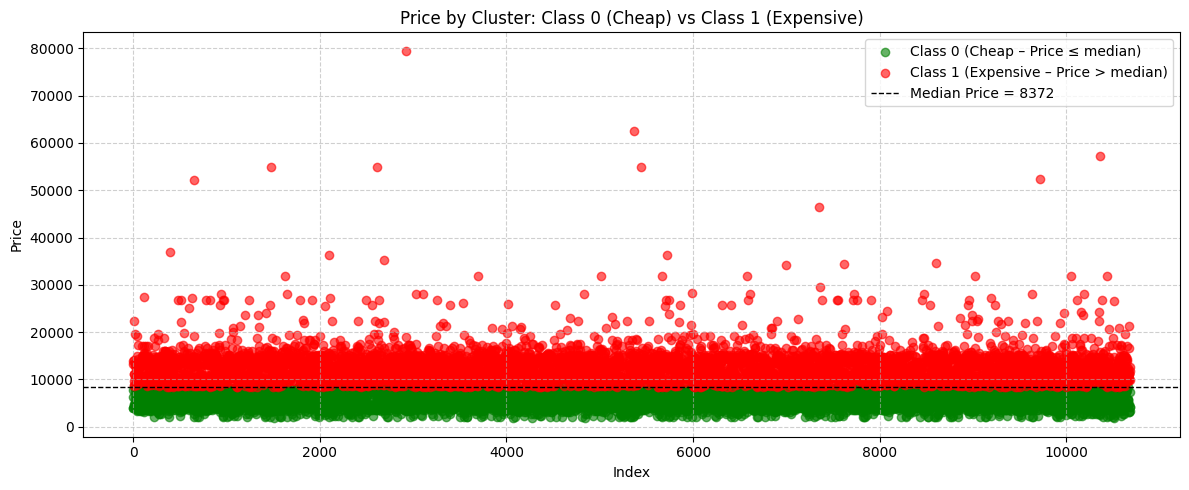


Reconstructed feature head (for NN input):
   Duration_Minutes_rec  Dep_Hour_rec  Arr_Hour_rec  Total_Stops_Num_rec
0             20.784612     14.316305     13.454355            -0.019724
1            986.136078      6.799053      9.184711             1.343685
2           1272.959598      5.735921      8.941882             1.735255
3            603.125698     19.796443     19.656077             0.687019
4            573.278809     17.717882     17.762668             0.671569
Epoch 100/1000, Loss: 0.4343
Epoch 200/1000, Loss: 0.4216
Epoch 300/1000, Loss: 0.4131
Epoch 400/1000, Loss: 0.4105
Epoch 500/1000, Loss: 0.4085
Epoch 600/1000, Loss: 0.4082
Epoch 700/1000, Loss: 0.4081
Epoch 800/1000, Loss: 0.4081
Epoch 900/1000, Loss: 0.4079
Epoch 1000/1000, Loss: 0.4078

Training Accuracy: 81.42%
Training Confusion Matrix:
[[2564 1194]
 [ 195 3524]]

Validation Accuracy: 82.22%
Validation Confusion Matrix:
[[1105  506]
 [  64 1530]]

Training Misclassification Error: 0.1858
Validation Misclass

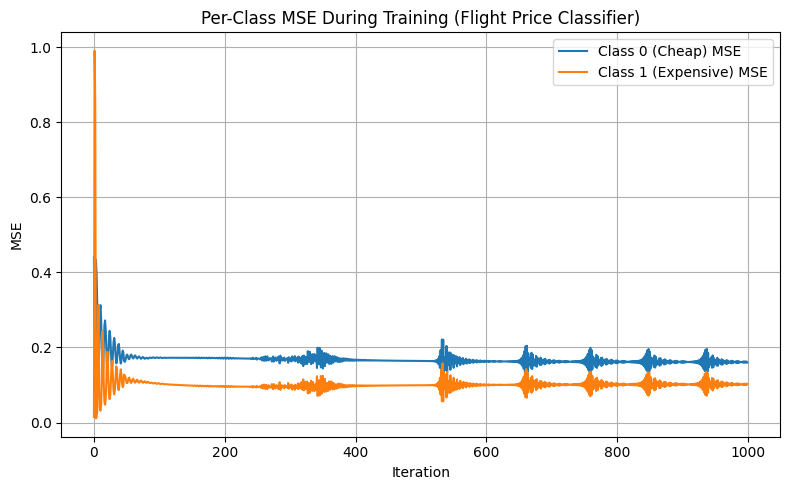

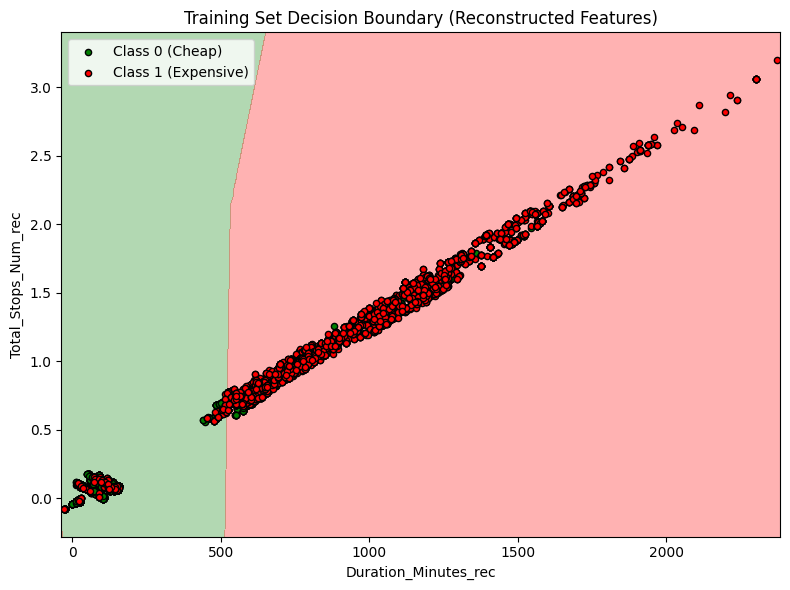

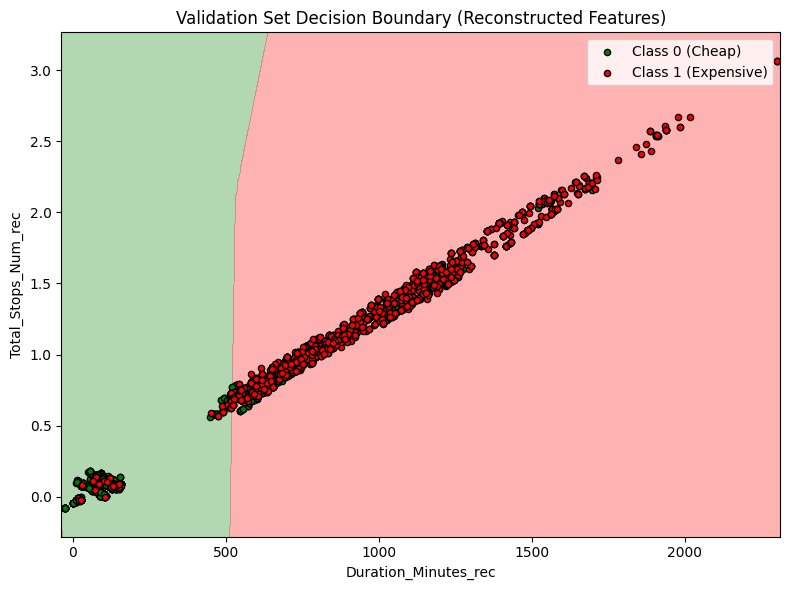

Trial 1/20 - Class 0 MSE: 0.0000, Class 1 MSE: 1.0000, Overall MSE: 0.4974
Trial 2/20 - Class 0 MSE: 0.3026, Class 1 MSE: 0.0677, Overall MSE: 0.1858
Trial 3/20 - Class 0 MSE: 0.0000, Class 1 MSE: 1.0000, Overall MSE: 0.4974
Trial 4/20 - Class 0 MSE: 0.0000, Class 1 MSE: 1.0000, Overall MSE: 0.4974
Trial 5/20 - Class 0 MSE: 0.2635, Class 1 MSE: 0.1486, Overall MSE: 0.2064
Trial 6/20 - Class 0 MSE: 0.3017, Class 1 MSE: 0.0536, Overall MSE: 0.1783
Trial 7/20 - Class 0 MSE: 0.3538, Class 1 MSE: 0.0282, Overall MSE: 0.1919
Trial 8/20 - Class 0 MSE: 0.2402, Class 1 MSE: 0.1599, Overall MSE: 0.2003
Trial 9/20 - Class 0 MSE: 0.3091, Class 1 MSE: 0.0470, Overall MSE: 0.1788
Trial 10/20 - Class 0 MSE: 0.2858, Class 1 MSE: 0.1261, Overall MSE: 0.2064
Trial 11/20 - Class 0 MSE: 0.2719, Class 1 MSE: 0.0809, Overall MSE: 0.1769
Trial 12/20 - Class 0 MSE: 0.2551, Class 1 MSE: 0.1270, Overall MSE: 0.1914
Trial 13/20 - Class 0 MSE: 0.2952, Class 1 MSE: 0.0536, Overall MSE: 0.1750
Trial 14/20 - Class 0

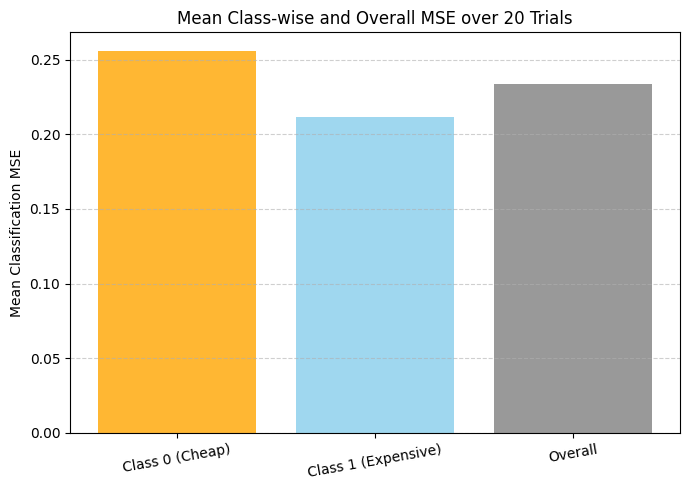

[Fine-tuned] Epoch 100/1000, Loss: 0.6931
[Fine-tuned] Epoch 200/1000, Loss: 0.6931
[Fine-tuned] Epoch 300/1000, Loss: 0.6931
[Fine-tuned] Epoch 400/1000, Loss: 0.6931
[Fine-tuned] Epoch 500/1000, Loss: 0.6931
[Fine-tuned] Epoch 600/1000, Loss: 0.6931
[Fine-tuned] Epoch 700/1000, Loss: 0.6931
[Fine-tuned] Epoch 800/1000, Loss: 0.6931
[Fine-tuned] Epoch 900/1000, Loss: 0.6931
[Fine-tuned] Epoch 1000/1000, Loss: 0.6931

Fine-tuned Training Accuracy: 50.26%
Fine-tuned Training Confusion Matrix:
[[3758    0]
 [3719    0]]

Fine-tuned Validation Accuracy: 50.27%
Fine-tuned Validation Confusion Matrix:
[[1611    0]
 [1594    0]]

[Fine-tuned] Training Misclassification Error:   0.4974
[Fine-tuned] Validation Misclassification Error: 0.4973


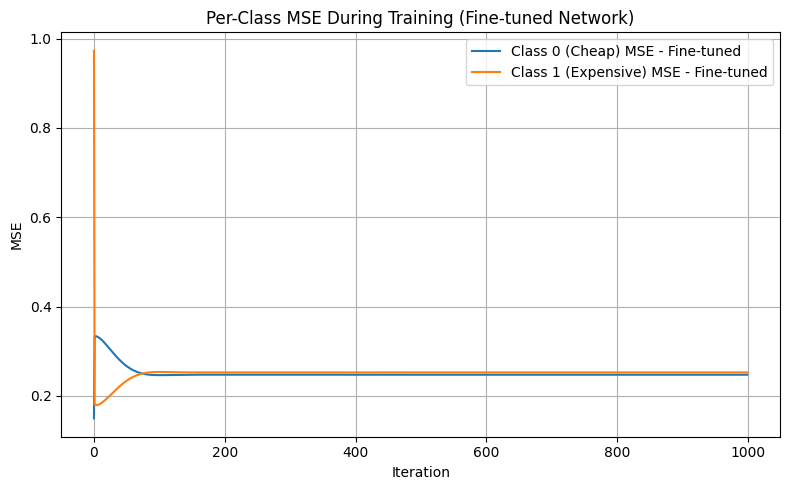

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# ============================================================
# PART A — Price: Summary, Clusters, and Scatter Plot
# ============================================================

FILE_PATH = "Data_Train.csv"

try:
    # 1. Load dataset
    df_raw = pd.read_csv(FILE_PATH)
    print("✅ Loaded flight dataset.")
    print("Shape:", df_raw.shape)
    print("Columns:", df_raw.columns.tolist())

    # Ensure Price is numeric
    df_raw["Price"] = pd.to_numeric(df_raw["Price"], errors="coerce")
    df_raw = df_raw.dropna(subset=["Price"])

    if df_raw.empty:
        raise ValueError("No valid numeric data found in 'Price'.")

    # 2. Summary stats for Price
    price_min = df_raw["Price"].min()
    price_max = df_raw["Price"].max()
    price_range = price_max - price_min
    price_median = df_raw["Price"].median()

    print("\n--- Summary Statistics (Price) ---")
    print(f"Min:    {price_min:.2f}")
    print(f"Max:    {price_max:.2f}")
    print(f"Range:  {price_range:.2f}")
    print(f"Median: {price_median:.2f}")

    # 3. Define binary cluster: cheap (0) vs expensive (1)
    df_raw["cluster"] = (df_raw["Price"] > price_median).astype(int)

    print("\n--- Cluster Counts (Class 0 = Cheap, Class 1 = Expensive) ---")
    print(
        df_raw["cluster"]
        .value_counts()
        .rename(index={0: "Class 0 (Cheap ≤ median)", 1: "Class 1 (Expensive > median)"})
    )

    # 4. Scatter plot of Price over index, colored by cluster
    plt.figure(figsize=(12, 5))

    colors = {
        0: "green",   # Class 0
        1: "red"      # Class 1
    }

    labels = {
        0: "Class 0 (Cheap – Price ≤ median)",
        1: "Class 1 (Expensive – Price > median)"
    }

    for c, g in df_raw.groupby("cluster"):
        plt.scatter(
            g.index,
            g["Price"],
            color=colors[c],
            alpha=0.6,
            label=labels[c],
        )

    plt.axhline(
        price_median,
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"Median Price = {price_median:.0f}"
    )

    plt.title("Price by Cluster: Class 0 (Cheap) vs Class 1 (Expensive)")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ File not found: {FILE_PATH}")
except Exception as e:
    print(f"⚠️ Error in PART A: {e}")


# ============================================================
# PART B — PCA (2 PCs) → Reconstruct → Neural Network on 𝑋̂
#          Predict: Cheap vs Expensive (cluster)
# ============================================================

try:
    # =========================
    # 1. Load again & Feature Engineering
    # =========================
    df = pd.read_csv(FILE_PATH)

    # --- Duration -> Duration_Minutes ---
    def parse_duration(s):
        s = str(s).strip()
        h = 0
        m = 0
        for part in s.split():
            if "h" in part:
                h = int(part.replace("h", ""))
            elif "m" in part:
                m = int(part.replace("m", ""))
        return h * 60 + m

    df["Duration_Minutes"] = df["Duration"].apply(parse_duration)

    # --- Dep_Time & Arrival_Time -> hours (0–23) ---
    def parse_hour(s):
        s = str(s).strip().split()[0]  # keep only 'HH:MM'
        try:
            return int(s.split(":")[0])
        except Exception:
            return np.nan

    df["Dep_Hour"] = df["Dep_Time"].apply(parse_hour)
    df["Arr_Hour"] = df["Arrival_Time"].apply(parse_hour)

    # --- Total_Stops -> numeric ---
    stop_map = {"non-stop": 0}
    for val in df["Total_Stops"].dropna().unique():
        if val not in stop_map:
            try:
                stop_map[val] = int(str(val).split()[0])  # '1 stop' -> 1
            except Exception:
                stop_map[val] = np.nan

    df["Total_Stops_Num"] = df["Total_Stops"].map(stop_map)

    # Keep Price and engineered numeric features
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

    # Drop rows with missing values in key columns
    feature_names = ["Duration_Minutes", "Dep_Hour", "Arr_Hour", "Total_Stops_Num"]
    df = df.dropna(subset=["Price"] + feature_names)

    # Binary target (same definition as Part A)
    price_median = df["Price"].median()
    df["cluster"] = (df["Price"] > price_median).astype(int)
    y = df["cluster"].values

    # =========================
    # 2. PCA with m* = 2 PCs on the 4 engineered features
    # =========================
    X_original_features = df[feature_names].values

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_original_features)

    # ---- Keep exactly 2 PCs (m* = 2) and reconstruct to feature space ----
    m_star = 2
    pca_reduced = PCA(n_components=m_star)
    X_pca_2 = pca_reduced.fit_transform(X_std)
    X_rec_std = pca_reduced.inverse_transform(X_pca_2)
    X_rec = scaler.inverse_transform(X_rec_std)

    # Build DataFrame of reconstructed features (𝑋̂ in feature space)
    rec_cols = [f"{name}_rec" for name in feature_names]
    df_rec = pd.DataFrame(X_rec, columns=rec_cols, index=df.index)

    # Combine reconstructed features with Price and cluster label
    df_model = pd.concat([df[["Price", "cluster"]], df_rec], axis=1)

    print("\nReconstructed feature head (for NN input):")
    print(df_model[rec_cols].head())

    # =========================
    # 3. X̂ and y for the neural network
    # =========================
    X = df_model[rec_cols].values       # shape (n_samples, 4)
    y = df_model["cluster"].values      # 0 = cheap, 1 = expensive

    # Train/Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # =========================
    # 4. Neural Network (m, 8, 4, 1)
    # =========================
    class TwoLayerNN(nn.Module):
        def __init__(self, input_size):
            super(TwoLayerNN, self).__init__()
            self.hidden1 = nn.Linear(input_size, 8)
            self.hidden2 = nn.Linear(8, 4)
            self.output = nn.Linear(4, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = torch.relu(self.hidden1(x))
            x = torch.relu(self.hidden2(x))
            x = self.sigmoid(self.output(x))
            return x

    model = TwoLayerNN(input_size=X.shape[1])  # input_size = 4 reconstructed features

    # =========================
    # 5. Loss and Optimizer
    # =========================
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # =========================
    # 6. Training + Tracking Class-wise MSE
    # =========================
    mse_class0 = []
    mse_class1 = []

    n_epochs = 1000
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # ---- Per-class MSE tracking ----
        with torch.no_grad():
            errors = (outputs - y_train_tensor) ** 2
            class0_mask = (y_train_tensor == 0).view(-1)
            class1_mask = (y_train_tensor == 1).view(-1)

            mse0 = errors[class0_mask].mean().item()
            mse1 = errors[class1_mask].mean().item()

            mse_class0.append(mse0)
            mse_class1.append(mse1)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

    # =========================
    # 7. Evaluation helpers
    # =========================
    def evaluate_model(X_tensor, y_tensor, name="Dataset"):
        with torch.no_grad():
            probs = model(X_tensor)
            pred = (probs >= 0.5).float()
            acc = (pred == y_tensor).sum() / y_tensor.size(0)
            cm = confusion_matrix(y_tensor.numpy().ravel(), pred.numpy().ravel())
            print(f"\n{name} Accuracy: {acc.item()*100:.2f}%")
            print(f"{name} Confusion Matrix:\n{cm}")
        return pred

    def misclassification_error(y_true, y_pred):
        return (y_true != y_pred).float().mean().item()

    train_pred = evaluate_model(X_train_tensor, y_train_tensor, "Training")
    val_pred = evaluate_model(X_val_tensor, y_val_tensor, "Validation")

    train_error = misclassification_error(y_train_tensor, train_pred)
    val_error = misclassification_error(y_val_tensor, val_pred)

    print(f"\nTraining Misclassification Error: {train_error:.4f}")
    print(f"Validation Misclassification Error: {val_error:.4f}")

    print("Final baseline Class 0 MSE:", mse_class0[-1])
    print("Final baseline Class 1 MSE:", mse_class1[-1])

    # =========================
    # 8. Plot MSE per class vs iteration
    # =========================
    plt.figure(figsize=(8, 5))
    plt.plot(mse_class0, label="Class 0 (Cheap) MSE")
    plt.plot(mse_class1, label="Class 1 (Expensive) MSE")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.title("Per-Class MSE During Training (Flight Price Classifier)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # =========================
    # 9. Decision Boundary Plot using 2 reconstructed features
    # =========================
    dur_idx = rec_cols.index("Duration_Minutes_rec")
    stops_idx = rec_cols.index("Total_Stops_Num_rec")

    # Mean of each reconstructed feature (used to fix the other dims)
    mean_vals = X.mean(axis=0)

    def plot_decision_boundary(X_arr, y_arr, model_obj, title="Decision Boundary"):
        plt.figure(figsize=(8, 6))

        x_min, x_max = X_arr[:, dur_idx].min() - 10, X_arr[:, dur_idx].max() + 10
        y_min, y_max = X_arr[:, stops_idx].min() - 0.2, X_arr[:, stops_idx].max() + 0.2

        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 200),
            np.linspace(y_min, y_max, 200)
        )

        # Build full 4D grid: two dims vary, other two fixed at mean
        grid_full = np.zeros((xx.size, X_arr.shape[1]))
        grid_full[:, :] = mean_vals
        grid_full[:, dur_idx] = xx.ravel()
        grid_full[:, stops_idx] = yy.ravel()

        grid_tensor = torch.tensor(grid_full, dtype=torch.float32)

        with torch.no_grad():
            Z = model_obj(grid_tensor).numpy().reshape(xx.shape)

        plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3,
                     colors=['green', 'red'])

        plt.scatter(X_arr[y_arr == 0, dur_idx], X_arr[y_arr == 0, stops_idx],
                    color='green', label='Class 0 (Cheap)', edgecolor='k', s=20)
        plt.scatter(X_arr[y_arr == 1, dur_idx], X_arr[y_arr == 1, stops_idx],
                    color='red', label='Class 1 (Expensive)', edgecolor='k', s=20)

        plt.xlabel("Duration_Minutes_rec")
        plt.ylabel("Total_Stops_Num_rec")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_decision_boundary(X_train, y_train, model,
                           "Training Set Decision Boundary (Reconstructed Features)")
    plot_decision_boundary(X_val, y_val, model,
                           "Validation Set Decision Boundary (Reconstructed Features)")

    # =========================
    # 10. Part III(iii): M random 80–20 trials
    # =========================
    M = 20  # number of random trials

    mse0_trials = []      # Class 0 (Cheap)
    mse1_trials = []      # Class 1 (Expensive)
    mse_overall_trials = []

    for trial in range(M):
        X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=None
        )

        X_train_tens = torch.tensor(X_train_t, dtype=torch.float32)
        y_train_tens = torch.tensor(y_train_t, dtype=torch.float32).view(-1, 1)
        X_test_tens  = torch.tensor(X_test_t, dtype=torch.float32)
        y_test_tens  = torch.tensor(y_test_t, dtype=torch.float32).view(-1, 1)

        model_t = TwoLayerNN(input_size=X.shape[1])
        criterion_t = nn.BCELoss()
        optimizer_t = optim.Adam(model_t.parameters(), lr=0.01)

        n_epochs_t = 500
        for epoch in range(n_epochs_t):
            optimizer_t.zero_grad()
            out_t = model_t(X_train_tens)
            loss_t = criterion_t(out_t, y_train_tens)
            loss_t.backward()
            optimizer_t.step()

        with torch.no_grad():
            probs_t = model_t(X_test_tens)
            preds_t = (probs_t >= 0.5).float()
            sq_err  = (preds_t - y_test_tens) ** 2

            overall_mse = sq_err.mean().item()

            mask0 = (y_test_tens == 0).view(-1)
            mask1 = (y_test_tens == 1).view(-1)

            mse0 = sq_err[mask0].mean().item()
            mse1 = sq_err[mask1].mean().item()

        mse0_trials.append(mse0)
        mse1_trials.append(mse1)
        mse_overall_trials.append(overall_mse)

        print(f"Trial {trial+1}/{M} - "
              f"Class 0 MSE: {mse0:.4f}, "
              f"Class 1 MSE: {mse1:.4f}, "
              f"Overall MSE: {overall_mse:.4f}")

    mean_mse0 = np.mean(mse0_trials)
    mean_mse1 = np.mean(mse1_trials)
    mean_mse_overall = np.mean(mse_overall_trials)

    print("\n=== Part III(iii): Mean classification MSE over "
          f"{M} trials (80–20 splits) ===")
    print(f"Class 0 (Cheap)     mean MSE: {mean_mse0:.4f}")
    print(f"Class 1 (Expensive) mean MSE: {mean_mse1:.4f}")
    print(f"Overall             mean MSE: {mean_mse_overall:.4f}")

    plt.figure(figsize=(7, 5))

    x_vals = [1, 2, 3]
    labels_plot = ["Class 0 (Cheap)", "Class 1 (Expensive)", "Overall"]
    means_plot  = [mean_mse0, mean_mse1, mean_mse_overall]

    plt.bar(x_vals, means_plot, color=["orange", "skyblue", "gray"], alpha=0.8)
    plt.xticks(x_vals, labels_plot, rotation=10)
    plt.ylabel("Mean Classification MSE")
    plt.title(f"Mean Class-wise and Overall MSE over {M} Trials")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # =========================
    # 11. Part IV: Fine-tuned network <m, 16, 8, 4, (c-1)>
    # =========================
    class FineTunedNN(nn.Module):
        def __init__(self, input_size):
            super(FineTunedNN, self).__init__()
            self.hidden1 = nn.Linear(input_size, 16)
            self.hidden2 = nn.Linear(16, 8)
            self.hidden3 = nn.Linear(8, 4)
            self.output  = nn.Linear(4, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = torch.relu(self.hidden1(x))
            x = torch.relu(self.hidden2(x))
            x = torch.relu(self.hidden3(x))
            x = self.sigmoid(self.output(x))
            return x

    fine_model = FineTunedNN(input_size=X.shape[1])
    criterion_ft = nn.BCELoss()
    optimizer_ft = optim.Adam(fine_model.parameters(), lr=0.01)

    n_epochs_ft = 1000
    mse_class0_ft = []
    mse_class1_ft = []

    for epoch in range(n_epochs_ft):
        optimizer_ft.zero_grad()
        out_ft = fine_model(X_train_tensor)
        loss_ft = criterion_ft(out_ft, y_train_tensor)
        loss_ft.backward()
        optimizer_ft.step()

        with torch.no_grad():
            errors_ft = (out_ft - y_train_tensor) ** 2
            mask0_ft = (y_train_tensor == 0).view(-1)
            mask1_ft = (y_train_tensor == 1).view(-1)

            mse0_ft = errors_ft[mask0_ft].mean().item()
            mse1_ft = errors_ft[mask1_ft].mean().item()

            mse_class0_ft.append(mse0_ft)
            mse_class1_ft.append(mse1_ft)

        if (epoch + 1) % 100 == 0:
            print(f"[Fine-tuned] Epoch {epoch+1}/{n_epochs_ft}, Loss: {loss_ft.item():.4f}")

    def evaluate_with_model(model_obj, X_tensor, y_tensor, name="Dataset"):
        with torch.no_grad():
            probs = model_obj(X_tensor)
            pred = (probs >= 0.5).float()
            acc = (pred == y_tensor).sum() / y_tensor.size(0)
            cm = confusion_matrix(y_tensor.numpy().ravel(), pred.numpy().ravel())
            print(f"\n{name} Accuracy: {acc.item()*100:.2f}%")
            print(f"{name} Confusion Matrix:\n{cm}")
        return pred

    ft_train_pred = evaluate_with_model(fine_model, X_train_tensor, y_train_tensor,
                                        "Fine-tuned Training")
    ft_val_pred   = evaluate_with_model(fine_model, X_val_tensor,   y_val_tensor,
                                        "Fine-tuned Validation")

    ft_train_err = misclassification_error(y_train_tensor, ft_train_pred)
    ft_val_err   = misclassification_error(y_val_tensor,   ft_val_pred)

    print(f"\n[Fine-tuned] Training Misclassification Error:   {ft_train_err:.4f}")
    print(f"[Fine-tuned] Validation Misclassification Error: {ft_val_err:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(mse_class0_ft, label="Class 0 (Cheap) MSE - Fine-tuned")
    plt.plot(mse_class1_ft, label="Class 1 (Expensive) MSE - Fine-tuned")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.title("Per-Class MSE During Training (Fine-tuned Network)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ File not found: {FILE_PATH}")
except Exception as e:
    print(f"⚠️ Error in PART B: {e}")


Remove Total Number of stop

Shape of original data: (10683, 11)
Columns: ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price']
       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR ? DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU ? IXR ? BBI ? BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL ? LKO ? BOM ? COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU ? NAG ? BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR ? NAG ? DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop   

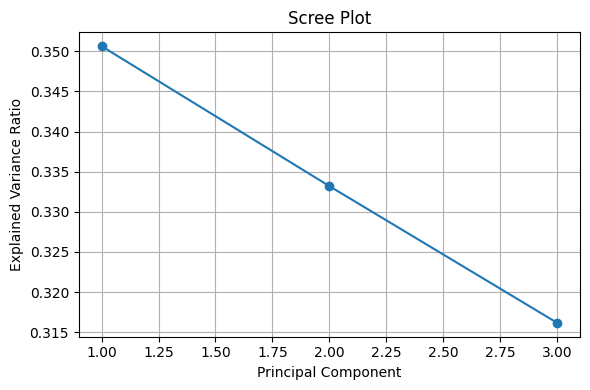

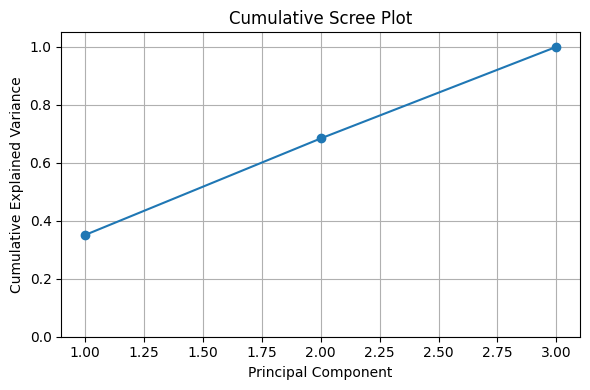

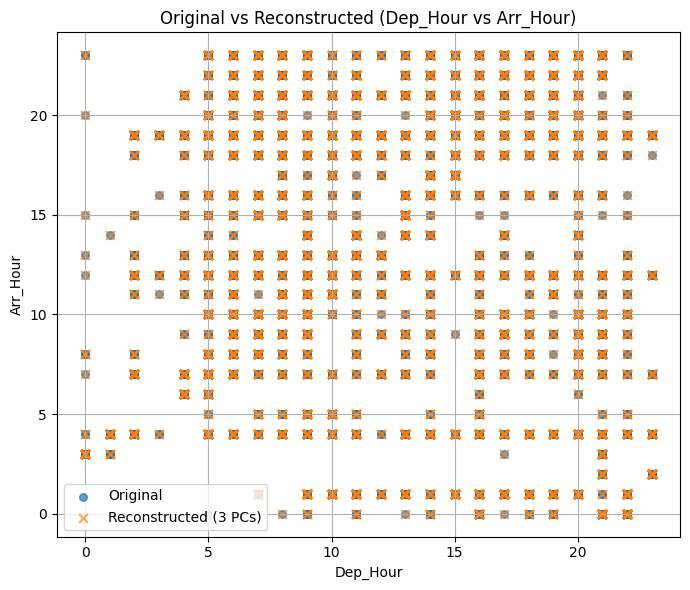

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ===============================
# 1. Load your dataset
# ===============================
file_path = "Data_Train.csv"   # adjust path if needed
df = pd.read_csv(file_path)

print("Shape of original data:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# ===============================
# 2. Feature Engineering (numeric)
# ===============================

# --- Duration -> Duration_Minutes ---
def parse_duration(s):
    """
    Convert '2h 50m', '19h', '50m' into total minutes (int).
    """
    s = str(s).strip()
    h = 0
    m = 0
    for part in s.split():
        if "h" in part:
            h = int(part.replace("h", ""))
        elif "m" in part:
            m = int(part.replace("m", ""))
    return h * 60 + m

df["Duration_Minutes"] = df["Duration"].apply(parse_duration)

# --- Dep_Time & Arrival_Time -> hours (0–23) ---
def parse_hour(s):
    """
    Take a time string like '22:20' or '01:10 22 Mar'
    and return the hour as integer.
    """
    s = str(s).strip().split()[0]  # keep only 'HH:MM'
    try:
        return int(s.split(":")[0])
    except Exception:
        return np.nan

df["Dep_Hour"] = df["Dep_Time"].apply(parse_hour)
df["Arr_Hour"] = df["Arrival_Time"].apply(parse_hour)

# --- Total_Stops -> numeric (still computed, but NOT used in PCA) ---
stop_map = {"non-stop": 0}
for val in df["Total_Stops"].dropna().unique():
    if val not in stop_map:
        # '1 stop', '2 stops', etc.
        try:
            stop_map[val] = int(str(val).split()[0])
        except Exception:
            stop_map[val] = np.nan

df["Total_Stops_Num"] = df["Total_Stops"].map(stop_map)

print("\nHead with engineered features:")
print(df[["Duration", "Duration_Minutes",
          "Dep_Time", "Dep_Hour",
          "Arrival_Time", "Arr_Hour",
          "Total_Stops", "Total_Stops_Num"]].head())

# ===============================
# 3. Build X matrix for PCA  (EXCLUDING Total_Stops_Num)
# ===============================
feature_names = ["Duration_Minutes", "Dep_Hour", "Arr_Hour"]  # <-- only 3 features

# Drop rows with missing values in these features
df_clean = df[feature_names].dropna()
X = df_clean.values
print("\nPCA will be performed on features:", feature_names)
print("Number of samples used for PCA:", X.shape[0])

# ===============================
# 4. Standardize the data
# ===============================
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# ===============================
# 5. Run PCA (all components)
# ===============================
pca = PCA()  # all components
X_pca = pca.fit_transform(X_std)

expl_var = pca.explained_variance_ratio_
cum_expl_var = np.cumsum(expl_var)

print("\nExplained variance ratio by component:")
for i, (ev, cev) in enumerate(zip(expl_var, cum_expl_var), start=1):
    print(f"PC{i}: {ev:.4f}  |  Cumulative: {cev:.4f}")

# ----- Choose m* such that cumulative explained variance >= 80% -----
threshold = 0.80
m_star = np.argmax(cum_expl_var >= threshold) + 1
print(f"\nChosen m* = {m_star} principal components "
      f"(cumulative variance ≥ {threshold*100:.0f}%).")

# ===============================
# 6. Reduced PCA: keep only first m* PCs
# ===============================
pca_reduced = PCA(n_components=m_star)
X_pca_m = pca_reduced.fit_transform(X_std)

print(f"\nUsing only the first {m_star} principal components.")
print("Shape of reduced PCA matrix:", X_pca_m.shape)

# --- Reconstruct from the m* PCs ---
X_rec_std = pca_reduced.inverse_transform(X_pca_m)
X_rec = scaler.inverse_transform(X_rec_std)

# Build DataFrames for original vs reconstructed
df_orig = df_clean.copy()
df_rec = pd.DataFrame(X_rec, columns=feature_names, index=df_clean.index)

# ===============================
# 7. Print reconstruction values
# ===============================
print("\nReconstructed values (first 10 rows):")
print(df_rec.head(10))

print("\nOriginal vs Reconstructed (first 10 rows):")
print(pd.concat(
    [df_orig.head(10).add_suffix("_orig"),
     df_rec.head(10).add_suffix("_rec")],
    axis=1
))

print("\nReconstruction error (first 10 rows):")
print((df_orig - df_rec).head(10))

# ===============================
# 8. Scree plot
# ===============================
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(expl_var) + 1), expl_var, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# 9. Cumulative scree plot
# ===============================
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cum_expl_var) + 1), cum_expl_var, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Scree Plot")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# 11. 2D overlay: Original vs Reconstructed (Dep_Hour vs Arr_Hour)
# ===============================
x_col = "Dep_Hour"
y_col = "Arr_Hour"

plt.figure(figsize=(7, 6))
plt.scatter(df_orig[x_col], df_orig[y_col],
            alpha=0.7, label="Original", s=30)
plt.scatter(df_rec[x_col], df_rec[y_col],
            alpha=0.7, label=f"Reconstructed ({m_star} PCs)",
            marker="x", s=40)

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Original vs Reconstructed ({x_col} vs {y_col})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Chcking Boundary Decision

✅ Loaded flight dataset.
Shape: (10683, 11)
Columns: ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price']

--- Summary Statistics (Price) ---
Min:    1759.00
Max:    79512.00
Range:  77753.00
Median: 8372.00

--- Cluster Counts (Class 0 = Cheap, Class 1 = Expensive) ---
cluster
Class 0 (Cheap ≤ median)        5370
Class 1 (Expensive > median)    5313
Name: count, dtype: int64


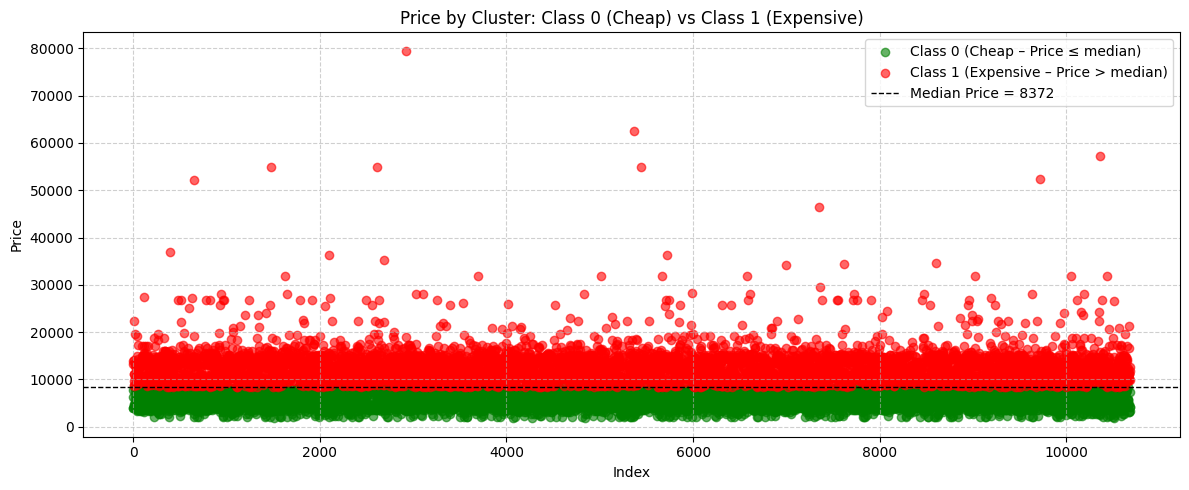


Reconstructed feature head (for NN input):
   Duration_Minutes_rec  Dep_Hour_rec  Arr_Hour_rec  Total_Stops_Num_rec
0            124.255002     22.044468      1.010721             0.060970
1            955.406132      4.503845     12.880379             1.319720
2           1314.391824      8.830477      3.959129             1.767567
3            575.809321     17.756194     22.941219             0.665716
4            546.870306     15.745441     20.938627             0.650974
Epoch 100/1000, Loss: 0.4627
Epoch 200/1000, Loss: 0.4483
Epoch 300/1000, Loss: 0.4381
Epoch 400/1000, Loss: 0.4308
Epoch 500/1000, Loss: 0.4256
Epoch 600/1000, Loss: 0.4222
Epoch 700/1000, Loss: 0.4201
Epoch 800/1000, Loss: 0.4290
Epoch 900/1000, Loss: 0.4226
Epoch 1000/1000, Loss: 0.4254

Training Accuracy: 81.85%
Training Confusion Matrix:
[[2628 1130]
 [ 227 3492]]

Validation Accuracy: 82.56%
Validation Confusion Matrix:
[[1141  470]
 [  89 1505]]

Training Misclassification Error: 0.1815
Validation Misclass

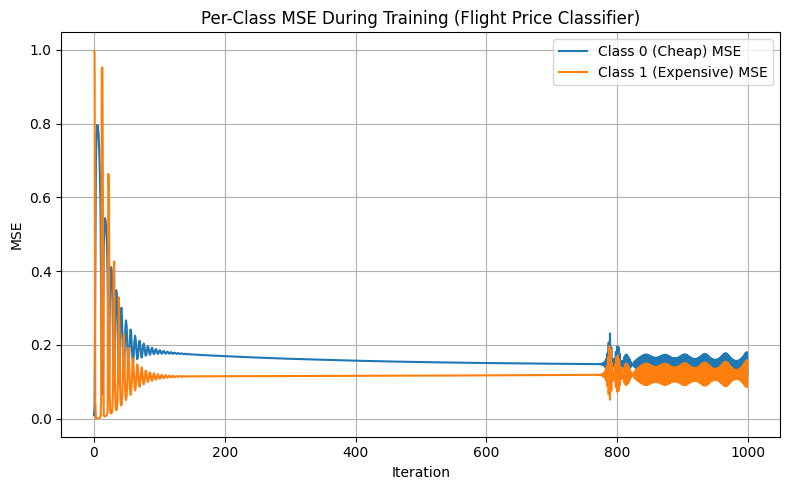

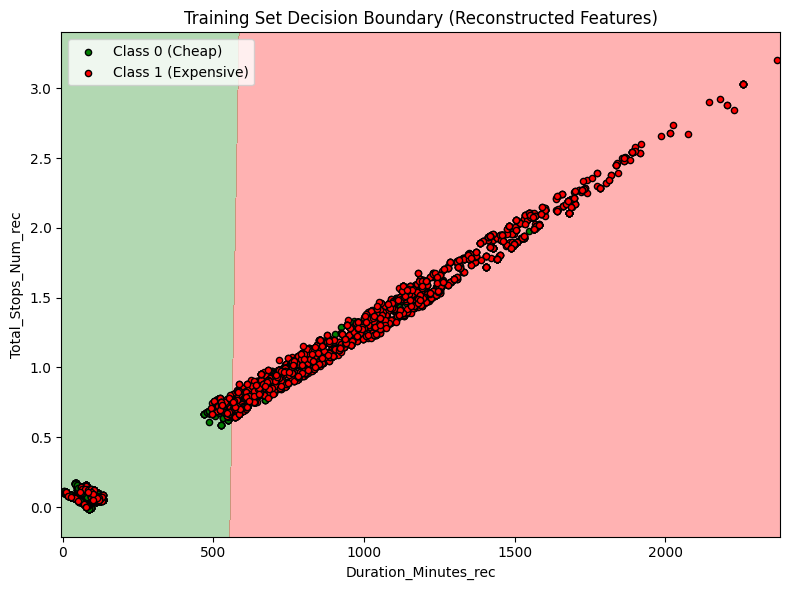

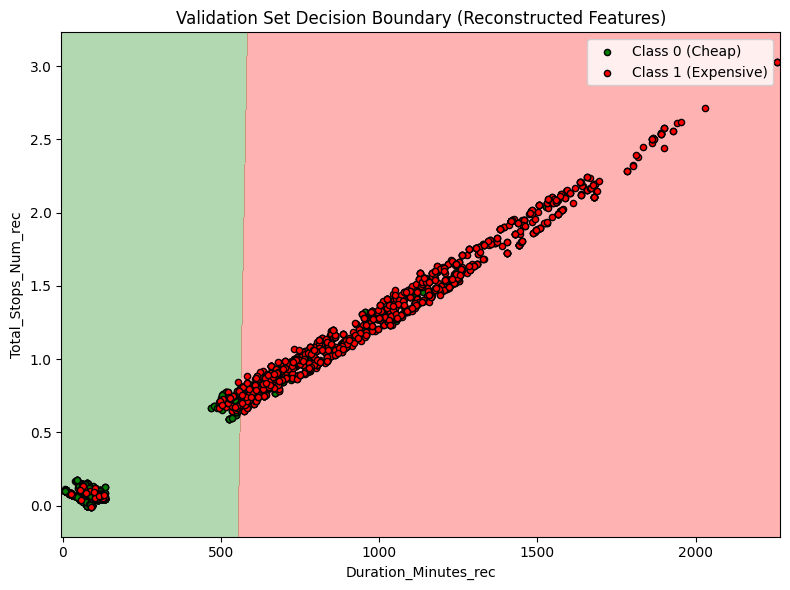

Trial 1/20 - Class 0 MSE: 0.0000, Class 1 MSE: 1.0000, Overall MSE: 0.4974
Trial 2/20 - Class 0 MSE: 0.2449, Class 1 MSE: 0.1383, Overall MSE: 0.1919
Trial 3/20 - Class 0 MSE: 0.3687, Class 1 MSE: 0.0235, Overall MSE: 0.1970
Trial 4/20 - Class 0 MSE: 0.2263, Class 1 MSE: 0.1279, Overall MSE: 0.1774
Trial 5/20 - Class 0 MSE: 0.2970, Class 1 MSE: 0.0724, Overall MSE: 0.1853
Trial 6/20 - Class 0 MSE: 0.2616, Class 1 MSE: 0.1336, Overall MSE: 0.1979
Trial 7/20 - Class 0 MSE: 0.3101, Class 1 MSE: 0.0517, Overall MSE: 0.1816
Trial 8/20 - Class 0 MSE: 0.2244, Class 1 MSE: 0.1308, Overall MSE: 0.1778
Trial 9/20 - Class 0 MSE: 0.3277, Class 1 MSE: 0.0499, Overall MSE: 0.1895
Trial 10/20 - Class 0 MSE: 0.2244, Class 1 MSE: 0.1590, Overall MSE: 0.1919
Trial 11/20 - Class 0 MSE: 0.3799, Class 1 MSE: 0.0263, Overall MSE: 0.2040
Trial 12/20 - Class 0 MSE: 0.0000, Class 1 MSE: 1.0000, Overall MSE: 0.4974
Trial 13/20 - Class 0 MSE: 0.2291, Class 1 MSE: 0.1289, Overall MSE: 0.1792
Trial 14/20 - Class 0

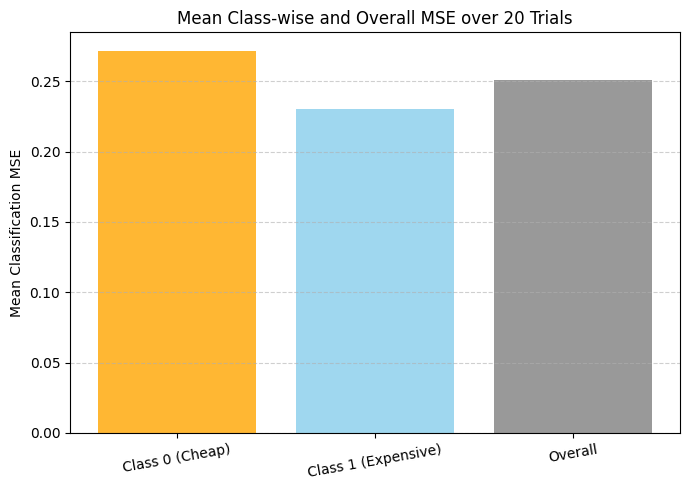

[Fine-tuned] Epoch 100/1000, Loss: 0.4754
[Fine-tuned] Epoch 200/1000, Loss: 0.4431
[Fine-tuned] Epoch 300/1000, Loss: 0.4290
[Fine-tuned] Epoch 400/1000, Loss: 0.4237
[Fine-tuned] Epoch 500/1000, Loss: 0.4216
[Fine-tuned] Epoch 600/1000, Loss: 0.4206
[Fine-tuned] Epoch 700/1000, Loss: 0.4198
[Fine-tuned] Epoch 800/1000, Loss: 0.4192
[Fine-tuned] Epoch 900/1000, Loss: 0.4187
[Fine-tuned] Epoch 1000/1000, Loss: 0.4182

Fine-tuned Training Accuracy: 80.01%
Fine-tuned Training Confusion Matrix:
[[2876  882]
 [ 613 3106]]

Fine-tuned Validation Accuracy: 81.44%
Fine-tuned Validation Confusion Matrix:
[[1251  360]
 [ 235 1359]]

[Fine-tuned] Training Misclassification Error:   0.1999
[Fine-tuned] Validation Misclassification Error: 0.1856


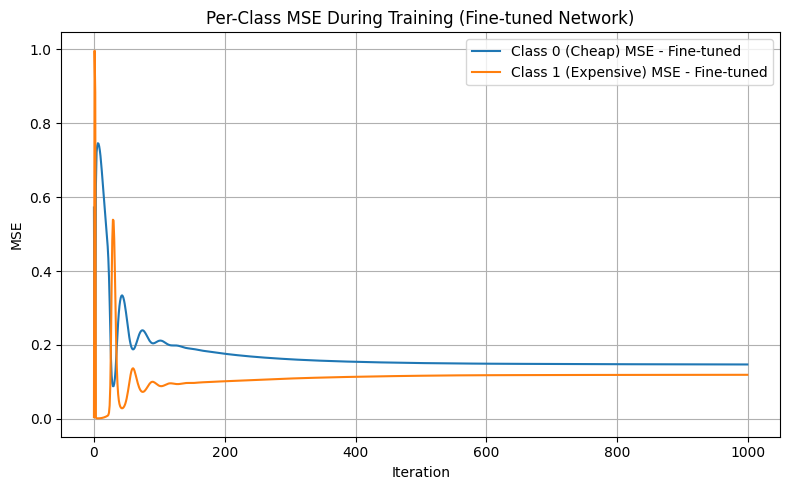

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# ============================================================
# PART A — Price: Summary, Clusters, and Scatter Plot
# ============================================================

FILE_PATH = "Data_Train.csv"

try:
    # 1. Load dataset
    df_raw = pd.read_csv(FILE_PATH)
    print("✅ Loaded flight dataset.")
    print("Shape:", df_raw.shape)
    print("Columns:", df_raw.columns.tolist())

    # Ensure Price is numeric
    df_raw["Price"] = pd.to_numeric(df_raw["Price"], errors="coerce")
    df_raw = df_raw.dropna(subset=["Price"])

    if df_raw.empty:
        raise ValueError("No valid numeric data found in 'Price'.")

    # 2. Summary stats for Price
    price_min = df_raw["Price"].min()
    price_max = df_raw["Price"].max()
    price_range = price_max - price_min
    price_median = df_raw["Price"].median()

    print("\n--- Summary Statistics (Price) ---")
    print(f"Min:    {price_min:.2f}")
    print(f"Max:    {price_max:.2f}")
    print(f"Range:  {price_range:.2f}")
    print(f"Median: {price_median:.2f}")

   # 3. Define binary cluster: cheap (0) vs expensive (1)
    df_raw["cluster"] = (df_raw["Price"] > price_median).astype(int)

    print("\n--- Cluster Counts (Class 0 = Cheap, Class 1 = Expensive) ---")
    print(
        df_raw["cluster"]
        .value_counts()
        .rename(index={0: "Class 0 (Cheap ≤ median)", 1: "Class 1 (Expensive > median)"})
    )

    # 4. Scatter plot of Price over index, colored by cluster
    plt.figure(figsize=(12, 5))

    colors = {
        0: "green",   # Class 0
        1: "red"      # Class 1
    }

    labels = {
        0: "Class 0 (Cheap – Price ≤ median)",
        1: "Class 1 (Expensive – Price > median)"
    }

    for c, g in df_raw.groupby("cluster"):
        plt.scatter(
            g.index,
            g["Price"],
            color=colors[c],
            alpha=0.6,
            label=labels[c],
        )

    plt.axhline(
        price_median,
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"Median Price = {price_median:.0f}"
    )

    plt.title("Price by Cluster: Class 0 (Cheap) vs Class 1 (Expensive)")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


except FileNotFoundError:
    print(f"❌ File not found: {FILE_PATH}")
except Exception as e:
    print(f"⚠️ Error in PART A: {e}")


# ============================================================
# PART B — PCA (3 PCs) → Reconstruct → Neural Network on 𝑋̂
#          Predict: Cheap vs Expensive (cluster)
# ============================================================

try:
    # =========================
    # 1. Load again & Feature Engineering
    # =========================
    df = pd.read_csv(FILE_PATH)

    # --- Duration -> Duration_Minutes ---
    def parse_duration(s):
        s = str(s).strip()
        h = 0
        m = 0
        for part in s.split():
            if "h" in part:
                h = int(part.replace("h", ""))
            elif "m" in part:
                m = int(part.replace("m", ""))
        return h * 60 + m

    df["Duration_Minutes"] = df["Duration"].apply(parse_duration)

    # --- Dep_Time & Arrival_Time -> hours (0–23) ---
    def parse_hour(s):
        s = str(s).strip().split()[0]  # keep only 'HH:MM'
        try:
            return int(s.split(":")[0])
        except Exception:
            return np.nan

    df["Dep_Hour"] = df["Dep_Time"].apply(parse_hour)
    df["Arr_Hour"] = df["Arrival_Time"].apply(parse_hour)

    # --- Total_Stops -> numeric ---
    stop_map = {"non-stop": 0}
    for val in df["Total_Stops"].dropna().unique():
        if val not in stop_map:
            try:
                stop_map[val] = int(str(val).split()[0])  # '1 stop' -> 1
            except Exception:
                stop_map[val] = np.nan

    df["Total_Stops_Num"] = df["Total_Stops"].map(stop_map)

    # Keep Price and engineered numeric features
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

    # Drop rows with missing values in key columns
    feature_names = ["Duration_Minutes", "Dep_Hour", "Arr_Hour", "Total_Stops_Num"]
    df = df.dropna(subset=["Price"] + feature_names)

    # Binary target (same definition as Part A)
    price_median = df["Price"].median()
    df["cluster"] = (df["Price"] > price_median).astype(int)
    y = df["cluster"].values

    # =========================
    # 2. PCA with 3 PCs on the 4 engineered features
    # =========================
    X_original_features = df[feature_names].values

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_original_features)

    # Keep 3 PCs (m* = 3) and reconstruct to feature space
    pca_reduced = PCA(n_components=3)
    X_pca_3 = pca_reduced.fit_transform(X_std)
    X_rec_std = pca_reduced.inverse_transform(X_pca_3)
    X_rec = scaler.inverse_transform(X_rec_std)

    # Build DataFrame of reconstructed features (𝑋̂ in feature space)
    rec_cols = [f"{name}_rec" for name in feature_names]
    df_rec = pd.DataFrame(X_rec, columns=rec_cols, index=df.index)

    # Combine reconstructed features with Price and cluster label
    df_model = pd.concat([df[["Price", "cluster"]], df_rec], axis=1)

    print("\nReconstructed feature head (for NN input):")
    print(df_model[rec_cols].head())

    # =========================
    # 3. X̂ and y for the neural network
    # =========================
    X = df_model[rec_cols].values       # shape (n_samples, 4)
    y = df_model["cluster"].values      # 0 = cheap, 1 = expensive

    # Train/Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # =========================
    # 4. Neural Network (m, 8, 4, 1)
    # =========================
    class TwoLayerNN(nn.Module):
        def __init__(self, input_size):
            super(TwoLayerNN, self).__init__()
            self.hidden1 = nn.Linear(input_size, 8)
            self.hidden2 = nn.Linear(8, 4)
            self.output = nn.Linear(4, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = torch.relu(self.hidden1(x))
            x = torch.relu(self.hidden2(x))
            x = self.sigmoid(self.output(x))
            return x

    model = TwoLayerNN(input_size=X.shape[1])  # input_size = 4 reconstructed features

    # =========================
    # 5. Loss and Optimizer
    # =========================
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # =========================
    # 6. Training + Tracking Class-wise MSE
    # =========================
    mse_class0 = []
    mse_class1 = []

    n_epochs = 1000
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # ---- Per-class MSE tracking ----
        with torch.no_grad():
            errors = (outputs - y_train_tensor) ** 2
            class0_mask = (y_train_tensor == 0).view(-1)
            class1_mask = (y_train_tensor == 1).view(-1)

            mse0 = errors[class0_mask].mean().item()
            mse1 = errors[class1_mask].mean().item()

            mse_class0.append(mse0)
            mse_class1.append(mse1)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")



    # =========================
    # 7. Evaluation helpers
    # =========================
    def evaluate_model(X_tensor, y_tensor, name="Dataset"):
        with torch.no_grad():
            probs = model(X_tensor)
            pred = (probs >= 0.5).float()
            acc = (pred == y_tensor).sum() / y_tensor.size(0)
            cm = confusion_matrix(y_tensor.numpy().ravel(), pred.numpy().ravel())
            print(f"\n{name} Accuracy: {acc.item()*100:.2f}%")
            print(f"{name} Confusion Matrix:\n{cm}")
        return pred

    def misclassification_error(y_true, y_pred):
        return (y_true != y_pred).float().mean().item()

    train_pred = evaluate_model(X_train_tensor, y_train_tensor, "Training")
    val_pred = evaluate_model(X_val_tensor, y_val_tensor, "Validation")

    train_error = misclassification_error(y_train_tensor, train_pred)
    val_error = misclassification_error(y_val_tensor, val_pred)

    print(f"\nTraining Misclassification Error: {train_error:.4f}")
    print(f"Validation Misclassification Error: {val_error:.4f}")

    print("Final baseline Class 0 MSE:", mse_class0[-1])
    print("Final baseline Class 1 MSE:", mse_class1[-1])
    # =========================
    # 8. Plot MSE per class vs iteration
    # =========================
    plt.figure(figsize=(8, 5))
    plt.plot(mse_class0, label="Class 0 (Cheap) MSE")
    plt.plot(mse_class1, label="Class 1 (Expensive) MSE")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.title("Per-Class MSE During Training (Flight Price Classifier)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # =========================
    # 9. Decision Boundary Plot using 2 reconstructed features
    # =========================
    # We'll visualize in the plane:
    #   Duration_Minutes_rec (x-axis) vs Total_Stops_Num_rec (y-axis)
    dur_idx = rec_cols.index("Duration_Minutes_rec")
    stops_idx = rec_cols.index("Total_Stops_Num_rec")

    # Mean of each reconstructed feature (used to fix the other dims)
    mean_vals = X.mean(axis=0)

    def plot_decision_boundary(X_arr, y_arr, model_obj, title="Decision Boundary"):
        plt.figure(figsize=(8, 6))

        x_min, x_max = X_arr[:, dur_idx].min() - 10, X_arr[:, dur_idx].max() + 10
        y_min, y_max = X_arr[:, stops_idx].min() - 0.2, X_arr[:, stops_idx].max() + 0.2

        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 200),
            np.linspace(y_min, y_max, 200)
        )

        # Build full 4D grid: two dims vary, other two fixed at mean
        grid_full = np.zeros((xx.size, X_arr.shape[1]))
        grid_full[:, :] = mean_vals  # start with means
        grid_full[:, dur_idx] = xx.ravel()
        grid_full[:, stops_idx] = yy.ravel()

        grid_tensor = torch.tensor(grid_full, dtype=torch.float32)

        with torch.no_grad():
            Z = model_obj(grid_tensor).numpy().reshape(xx.shape)

        # Background: decision regions
        plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3,
                     colors=['green', 'red'])

        # Overlay data points (projected to the same 2 dims)
        plt.scatter(X_arr[y_arr == 0, dur_idx], X_arr[y_arr == 0, stops_idx],
                    color='green', label='Class 0 (Cheap)', edgecolor='k', s=20)
        plt.scatter(X_arr[y_arr == 1, dur_idx], X_arr[y_arr == 1, stops_idx],
                    color='red', label='Class 1 (Expensive)', edgecolor='k', s=20)

        plt.xlabel("Duration_Minutes_rec")
        plt.ylabel("Total_Stops_Num_rec")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_decision_boundary(X_train, y_train, model,
                           "Training Set Decision Boundary (Reconstructed Features)")
    plot_decision_boundary(X_val, y_val, model,
                           "Validation Set Decision Boundary (Reconstructed Features)")

    # =========================
    # 10. Part III(iii): M random 80–20 trials
    # =========================
    M = 20  # number of random trials

    mse0_trials = []      # Class 0 (Cheap)
    mse1_trials = []      # Class 1 (Expensive)
    mse_overall_trials = []

    for trial in range(M):
        X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=None
        )

        X_train_tens = torch.tensor(X_train_t, dtype=torch.float32)
        y_train_tens = torch.tensor(y_train_t, dtype=torch.float32).view(-1, 1)
        X_test_tens  = torch.tensor(X_test_t,  dtype=torch.float32)
        y_test_tens  = torch.tensor(y_test_t,  dtype=torch.float32).view(-1, 1)

        model_t = TwoLayerNN(input_size=X.shape[1])
        criterion_t = nn.BCELoss()
        optimizer_t = optim.Adam(model_t.parameters(), lr=0.01)

        n_epochs_t = 500
        for epoch in range(n_epochs_t):
            optimizer_t.zero_grad()
            out_t = model_t(X_train_tens)
            loss_t = criterion_t(out_t, y_train_tens)
            loss_t.backward()
            optimizer_t.step()

        with torch.no_grad():
            probs_t = model_t(X_test_tens)
            preds_t = (probs_t >= 0.5).float()
            sq_err  = (preds_t - y_test_tens) ** 2

            overall_mse = sq_err.mean().item()

            mask0 = (y_test_tens == 0).view(-1)
            mask1 = (y_test_tens == 1).view(-1)

            mse0 = sq_err[mask0].mean().item()
            mse1 = sq_err[mask1].mean().item()

        mse0_trials.append(mse0)
        mse1_trials.append(mse1)
        mse_overall_trials.append(overall_mse)

        print(f"Trial {trial+1}/{M} - "
              f"Class 0 MSE: {mse0:.4f}, "
              f"Class 1 MSE: {mse1:.4f}, "
              f"Overall MSE: {overall_mse:.4f}")

    mean_mse0 = np.mean(mse0_trials)
    mean_mse1 = np.mean(mse1_trials)
    mean_mse_overall = np.mean(mse_overall_trials)

    print("\n=== Part III(iii): Mean classification MSE over "
          f"{M} trials (80–20 splits) ===")
    print(f"Class 0 (Cheap)     mean MSE: {mean_mse0:.4f}")
    print(f"Class 1 (Expensive) mean MSE: {mean_mse1:.4f}")
    print(f"Overall             mean MSE: {mean_mse_overall:.4f}")

    plt.figure(figsize=(7, 5))

    x_vals = [1, 2, 3]
    labels_plot = ["Class 0 (Cheap)", "Class 1 (Expensive)", "Overall"]
    means_plot  = [mean_mse0, mean_mse1, mean_mse_overall]

    # --- Bar Plot Version ---
    plt.bar(x_vals, means_plot, color=["orange", "skyblue", "gray"], alpha=0.8)

    plt.xticks(x_vals, labels_plot, rotation=10)
    plt.ylabel("Mean Classification MSE")
    plt.title(f"Mean Class-wise and Overall MSE over {M} Trials")
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


    # =========================
    # 11. Part IV: Fine-tuned network <m, 16, 8, 4, (c-1)>
    # =========================
    class FineTunedNN(nn.Module):
        def __init__(self, input_size):
            super(FineTunedNN, self).__init__()
            self.hidden1 = nn.Linear(input_size, 16)
            self.hidden2 = nn.Linear(16, 8)
            self.hidden3 = nn.Linear(8, 4)
            self.output  = nn.Linear(4, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = torch.relu(self.hidden1(x))
            x = torch.relu(self.hidden2(x))
            x = torch.relu(self.hidden3(x))
            x = self.sigmoid(self.output(x))
            return x

    fine_model = FineTunedNN(input_size=X.shape[1])
    criterion_ft = nn.BCELoss()
    optimizer_ft = optim.Adam(fine_model.parameters(), lr=0.01)

    n_epochs_ft = 1000
    mse_class0_ft = []
    mse_class1_ft = []

    for epoch in range(n_epochs_ft):
        optimizer_ft.zero_grad()
        out_ft = fine_model(X_train_tensor)
        loss_ft = criterion_ft(out_ft, y_train_tensor)
        loss_ft.backward()
        optimizer_ft.step()

        with torch.no_grad():
            errors_ft = (out_ft - y_train_tensor) ** 2
            mask0_ft = (y_train_tensor == 0).view(-1)
            mask1_ft = (y_train_tensor == 1).view(-1)

            mse0_ft = errors_ft[mask0_ft].mean().item()
            mse1_ft = errors_ft[mask1_ft].mean().item()

            mse_class0_ft.append(mse0_ft)
            mse_class1_ft.append(mse1_ft)

        if (epoch + 1) % 100 == 0:
            print(f"[Fine-tuned] Epoch {epoch+1}/{n_epochs_ft}, Loss: {loss_ft.item():.4f}")

    def evaluate_with_model(model_obj, X_tensor, y_tensor, name="Dataset"):
        with torch.no_grad():
            probs = model_obj(X_tensor)
            pred = (probs >= 0.5).float()
            acc = (pred == y_tensor).sum() / y_tensor.size(0)
            cm = confusion_matrix(y_tensor.numpy().ravel(), pred.numpy().ravel())
            print(f"\n{name} Accuracy: {acc.item()*100:.2f}%")
            print(f"{name} Confusion Matrix:\n{cm}")
        return pred

    ft_train_pred = evaluate_with_model(fine_model, X_train_tensor, y_train_tensor,
                                        "Fine-tuned Training")
    ft_val_pred   = evaluate_with_model(fine_model, X_val_tensor,   y_val_tensor,
                                        "Fine-tuned Validation")

    ft_train_err = misclassification_error(y_train_tensor, ft_train_pred)
    ft_val_err   = misclassification_error(y_val_tensor,   ft_val_pred)

    print(f"\n[Fine-tuned] Training Misclassification Error:   {ft_train_err:.4f}")
    print(f"[Fine-tuned] Validation Misclassification Error: {ft_val_err:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(mse_class0_ft, label="Class 0 (Cheap) MSE - Fine-tuned")
    plt.plot(mse_class1_ft, label="Class 1 (Expensive) MSE - Fine-tuned")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.title("Per-Class MSE During Training (Fine-tuned Network)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    x_vals = [1, 2, 3]

except FileNotFoundError:
    print(f"❌ File not found: {FILE_PATH}")
except Exception as e:
    print(f"⚠️ Error in PART B: {e}")
